In [1]:
# Import Libraries and modules
# libraries that are used for analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
pd.set_option('display.max_columns', 500)
plt.style.use('ggplot')
# to import datetime library
from datetime import datetime
import datetime as dt

# libraries used to pre-process
from sklearn import preprocessing, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ParameterGrid

# libraries used to implement models

from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_components_plotly
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# libraries to evaluate performance
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error

In [4]:
#Dataset Loading
file_path_trip = '../src/data/trips_2022.csv'
trips_2022 = pd.read_csv(file_path_trip)

In [5]:
# separate in quadrants
def get_cuadrante(longitud, latitud):
    if -58.43 < longitud < -58.35 and -34.60 < latitud < -34.54:
        return 'NE'
    elif -58.55 < longitud < -58.43 and -34.60 < latitud < -34.54:
        return 'NO'
    elif -58.43 < longitud < -58.35 and -34.68 < latitud < -34.60:
        return 'SE'
    elif -58.55 < longitud < -58.43 and -34.68 < latitud < -34.60:
        return 'SO'
    else:
        return 'SO'

In [6]:
#quadrants to origin and destination stations
trips_2022['QO'] = trips_2022.apply(lambda row: get_cuadrante(row['long_estacion_origen'], row['lat_estacion_origen']), axis=1)
trips_2022['QD'] = trips_2022.apply(lambda row: get_cuadrante(row['long_estacion_destino'], row['lat_estacion_destino']), axis=1)

c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


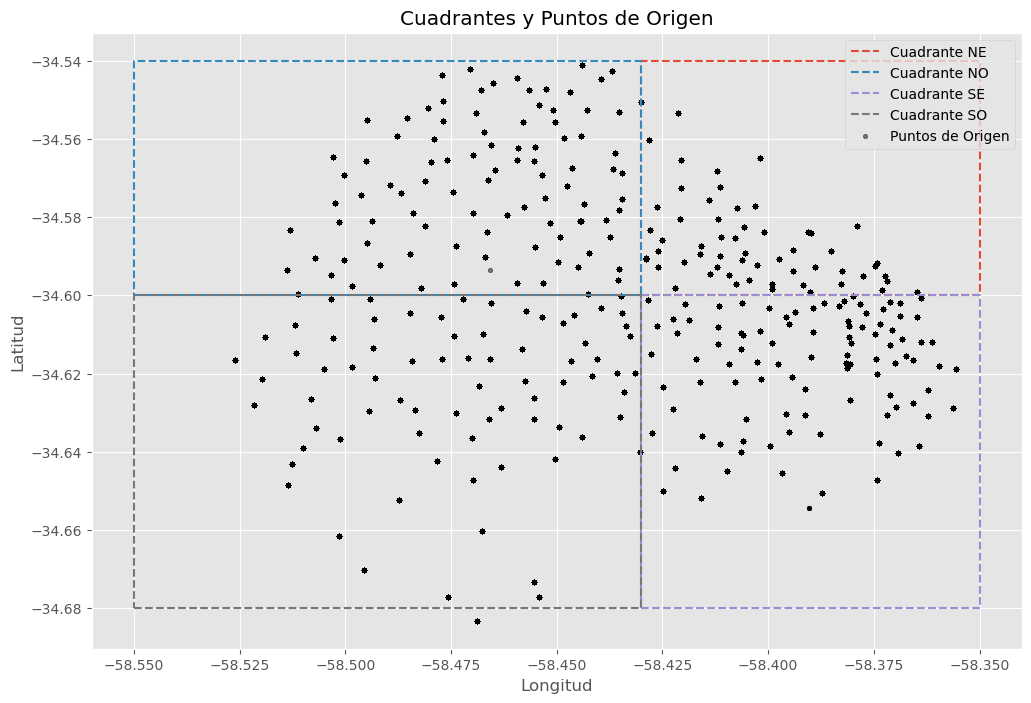

In [7]:
# Definir límites de los cuadrantes
cuadrantes = {
    'NE': {'lon_min': -58.43, 'lon_max': -58.35, 'lat_min': -34.60, 'lat_max': -34.54},
    'NO': {'lon_min': -58.55, 'lon_max': -58.43, 'lat_min': -34.60, 'lat_max': -34.54},
    'SE': {'lon_min': -58.43, 'lon_max': -58.35, 'lat_min': -34.68, 'lat_max': -34.60},
    'SO': {'lon_min': -58.55, 'lon_max': -58.43, 'lat_min': -34.68, 'lat_max': -34.60}
}

# Crear el gráfico
plt.figure(figsize=(12, 8))

# Graficar los cuadrantes
for cuadrante, limites in cuadrantes.items():
    plt.plot([limites['lon_min'], limites['lon_max'], limites['lon_max'], limites['lon_min'], limites['lon_min']],
             [limites['lat_min'], limites['lat_min'], limites['lat_max'], limites['lat_max'], limites['lat_min']],
             label=f'Cuadrante {cuadrante}', linestyle='--')

# Graficar los puntos de origen
plt.scatter(trips_2022['long_estacion_origen'], trips_2022['lat_estacion_origen'], c='black', s=10, alpha=0.5, label='Puntos de Origen')

# Configurar el gráfico
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Cuadrantes y Puntos de Origen')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

Dataset First View

In [8]:
trips_2022.columns

Index(['Unnamed: 0', 'X', 'Id_recorrido', 'duracion_recorrido',
       'fecha_origen_recorrido', 'id_estacion_origen',
       'nombre_estacion_origen', 'direccion_estacion_origen',
       'long_estacion_origen', 'lat_estacion_origen',
       'fecha_destino_recorrido', 'id_estacion_destino',
       'nombre_estacion_destino', 'direccion_estacion_destino',
       'long_estacion_destino', 'lat_estacion_destino', 'id_usuario',
       'modelo_bicicleta', 'Género', 'QO', 'QD'],
      dtype='object')

 Preprocesar la base de datos. Definir criterio de outliers y excluirlos

In [9]:
trips_2022.shape

(2922805, 21)

In [10]:
trips_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922805 entries, 0 to 2922804
Data columns (total 21 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Unnamed: 0                  int64  
 1   X                           int64  
 2   Id_recorrido                object 
 3   duracion_recorrido          object 
 4   fecha_origen_recorrido      object 
 5   id_estacion_origen          object 
 6   nombre_estacion_origen      object 
 7   direccion_estacion_origen   object 
 8   long_estacion_origen        float64
 9   lat_estacion_origen         float64
 10  fecha_destino_recorrido     object 
 11  id_estacion_destino         object 
 12  nombre_estacion_destino     object 
 13  direccion_estacion_destino  object 
 14  long_estacion_destino       float64
 15  lat_estacion_destino        float64
 16  id_usuario                  object 
 17  modelo_bicicleta            object 
 18  Género                      object 
 19  QO                   

In [11]:
# Identificar los id que se repiten más de una vez
id_counts = trips_2022['Id_recorrido'].value_counts()
repeated_ids = id_counts[id_counts > 1].index
# Eliminar las filas con Id_recorrido repetidos
trips_2022 = trips_2022[~trips_2022['Id_recorrido'].isin(repeated_ids)]
repeated_ids

Index([], dtype='object', name='Id_recorrido')

In [12]:
# Clone data
data = trips_2022.copy()

Features 

In [13]:
#TRABAJO CON FECHAS
# Convertir las columnas de fecha a tipo datetime
data['fecha_origen_recorrido'] = pd.to_datetime(data['fecha_origen_recorrido'], errors='coerce')
data['fecha_destino_recorrido'] = pd.to_datetime(data['fecha_destino_recorrido'], errors='coerce')

# Separar en columnas de fecha y hora
data['fecha_origen'] = data['fecha_origen_recorrido'].dt.date
data['hora_origen'] = data['fecha_origen_recorrido'].dt.time
#trips_2022['fecha_destino'] = trips_2022['fecha_destino_recorrido'].dt.date
#trips_2022['hora_destino'] = trips_2022['fecha_destino_recorrido'].dt.time

# Asignar día de la semana (1=Lunes, 7=Domingo)
data['dia_semana_origen'] = data['fecha_origen_recorrido'].dt.dayofweek + 1
#trips_2022['dia_semana_destino'] = trips_2022['fecha_destino_recorrido'].dt.dayofweek + 1

# Definir los días laborales (1=Lunes, ..., 5=Viernes)
data['dia_laboral'] = data['dia_semana_origen'].apply(lambda x: 1 if x < 6 else 0)
#trips_2022['dia_laboral_destino'] = trips_2022['dia_semana_destino'].apply(lambda x: 1 if x < 6 else 0)

# Crear la columna Dia como integer
data['dia'] = data['fecha_origen_recorrido'].dt.day
# Crear la columna Mes como integer
data['mes'] = data['fecha_origen_recorrido'].dt.month
# Crear la columna Año como integer
data['año'] = data['fecha_origen_recorrido'].dt.year

#Lista de feriados en 2022
feriados = pd.to_datetime([
    '2022-01-01', '2022-02-28', '2022-03-01', '2022-03-24', '2022-04-02',
    '2022-04-15', '2022-05-01', '2022-05-18', '2022-05-25', '2022-06-17',
    '2022-06-20', '2022-07-09', '2022-08-15', '2022-10-07', '2022-10-10', 
    '2022-11-20', '2022-11-21','2022-12-08', '2022-12-08', '2022-12-09',
    '2022-12-25'
])

# Crear la columna Feriado
data['feriado'] = data['fecha_origen_recorrido'].apply(lambda x: 1 if x.date() in feriados.date else 0)

In [14]:
#Eliminar columnas que no se utilizarán
data = data.drop(columns=['Unnamed: 0', 'X', 'fecha_destino_recorrido', 'fecha_origen_recorrido', 'nombre_estacion_origen', 'nombre_estacion_destino', 
                                      'direccion_estacion_origen', 'direccion_estacion_destino', 'long_estacion_origen',	'lat_estacion_origen',	
                                      'id_estacion_destino',	'long_estacion_destino',	'lat_estacion_destino', 'id_usuario', 
                                       'hora_origen'])

In [15]:
# Reemplazar comas por puntos para interpretar los valores como números decimales
data['duracion_recorrido'] = data['duracion_recorrido'].str.replace(',', '').astype(int)
# Convertir la duración de segundos a minutos
data['duracion_recorrido'] = data['duracion_recorrido'] / 60

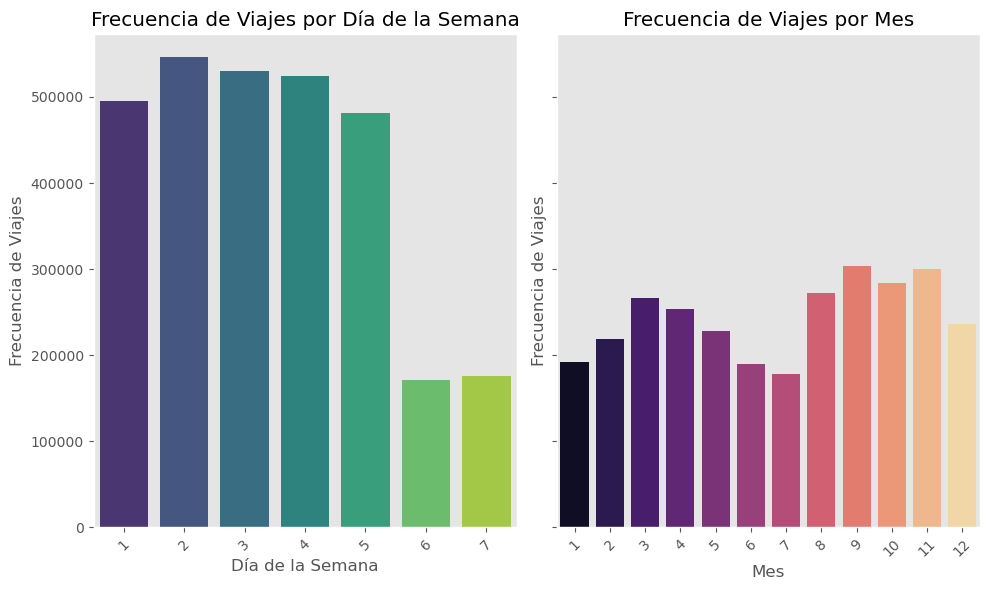

In [16]:
# Contar la frecuencia de viajes por día de la semana
frecuencia_dia_semana = data['dia_semana_origen'].value_counts().sort_index()
# Contar la frecuencia de viajes por mes
frecuencia_mes = data['mes'].value_counts().sort_index()
# subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
# Graficar Frecuencia de Viajes por Día de la Semana
sns.barplot(x=frecuencia_dia_semana.index, y=frecuencia_dia_semana.values, palette="viridis", ax=axes[0])
axes[0].set_xlabel('Día de la Semana')
axes[0].set_ylabel('Frecuencia de Viajes')
axes[0].set_title('Frecuencia de Viajes por Día de la Semana')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y')
# Graficar Frecuencia de Viajes por Mes
sns.barplot(x=frecuencia_mes.index, y=frecuencia_mes.values, palette="magma", ax=axes[1])
axes[1].set_xlabel('Mes')
axes[1].set_ylabel('Frecuencia de Viajes')
axes[1].set_title('Frecuencia de Viajes por Mes')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y')
plt.tight_layout()
plt.show()

Observacion: El uso de las Bicicletas es mas fuerte en la semana, siendo los fines de semanas menos frecuentadas. Luego si vamos al mensual, se nota la estacionalidad, hay una caida de la demanda en los meses mas fríos y calurosos, volviendo a aumentar para la primavera.

ESTUDIO OUTLIERS Y MISSINS DATA

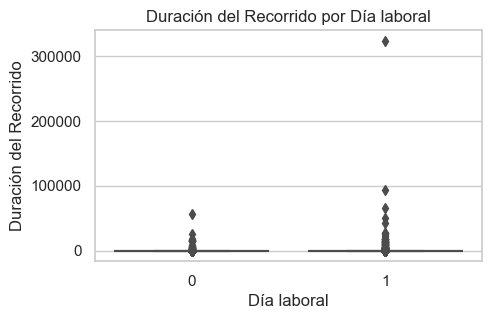

In [17]:
sns.set(style="whitegrid")
#gráfica de duración del recorrido por día festivo
plt.figure(figsize=(5, 3))
sns.boxplot(x='dia_laboral', y='duracion_recorrido', data=data)
plt.title('Duración del Recorrido por Día laboral')
plt.xlabel('Día laboral')
plt.ylabel('Duración del Recorrido')
plt.show()

Outliers - winsorization 1%

In [18]:
# Calcular los percentiles 1% y 99%
p_1 = data['duracion_recorrido'].quantile(0.01)
p_99 = data['duracion_recorrido'].quantile(0.99)
# Aplicar Winsorization: reemplazar valores por los límites
data['duracion_recorrido_w'] = np.clip(data['duracion_recorrido'], p_1, p_99)
print(data[['duracion_recorrido', 'duracion_recorrido_w']].head())

   duracion_recorrido  duracion_recorrido_w
0           43.500000             43.500000
1            9.083333              9.083333
2           34.350000             34.350000
3          212.466667             86.600000
4           72.283333             72.283333


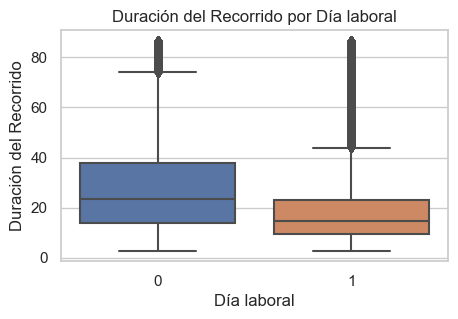

In [19]:
sns.set(style="whitegrid")
#gráfica de duración del recorrido por día festivo
plt.figure(figsize=(5, 3))
sns.boxplot(x='dia_laboral', y='duracion_recorrido_w', data=data)
plt.title('Duración del Recorrido por Día laboral')
plt.xlabel('Día laboral')
plt.ylabel('Duración del Recorrido')
plt.show()

c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


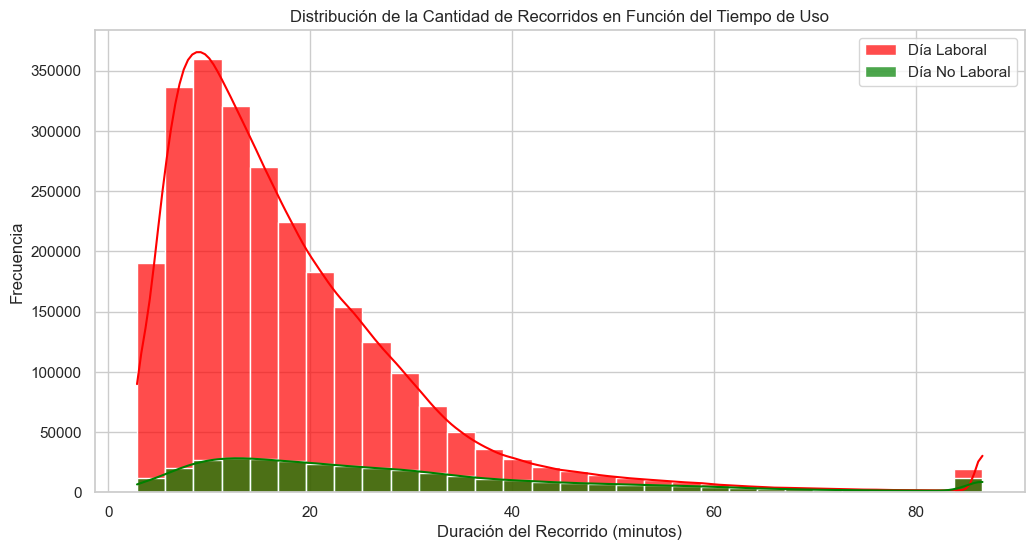

In [20]:
# Grafica de la distribución de recorridos en días laborales y no laborales
plt.figure(figsize=(12, 6))
sns.histplot(
    data[data['dia_laboral'] == 1]['duracion_recorrido_w'],
    color='red', label='Día Laboral', kde=True,
    bins=30, alpha=0.7
)
sns.histplot(
    data[data['dia_laboral'] == 0]['duracion_recorrido_w'],
    color='green', label='Día No Laboral', kde=True,
    bins=30, alpha=0.7
)
plt.xlabel('Duración del Recorrido (minutos)')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Cantidad de Recorridos en Función del Tiempo de Uso')
plt.legend()
plt.grid(True)
plt.show()

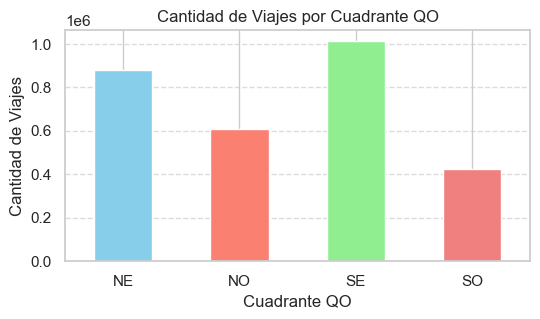

In [21]:
# Cantidad de viajes por cada cuadrante
counts = data['QO'].value_counts()
for quadrant in ['NE', 'NO', 'SE', 'SO']:
    if quadrant not in counts:
        counts[quadrant] = 0

# Ordenar los cuadrantes y reindexar
counts = counts.reindex(['NE', 'NO', 'SE', 'SO'])
plt.figure(figsize=(6, 3))
counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen', 'lightcoral'])
plt.title('Cantidad de Viajes por Cuadrante QO')
plt.xlabel('Cuadrante QO')
plt.ylabel('Cantidad de Viajes')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [22]:
# Contar los valores únicos de 'id_estacion_origen' por cuadrante de 'QO'
counts_per_qo = data.groupby('QO')['id_estacion_origen'].nunique()
counts_per_qo

QO
NE     57
NO     98
SE    100
SO     76
Name: id_estacion_origen, dtype: int64

Duracion del recorrido - tiempo de uso de las bicis

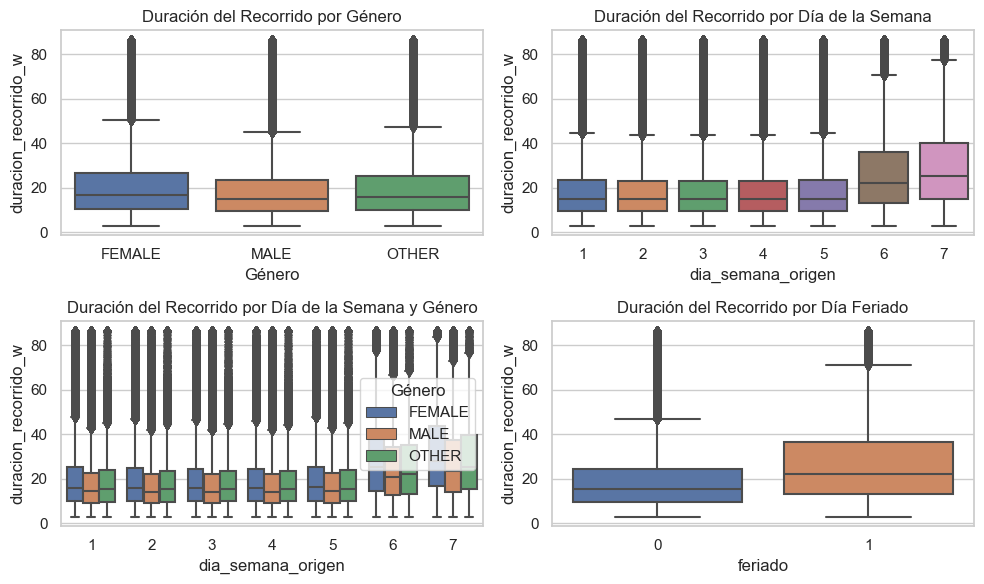

In [23]:
# estilo de los gráficos
sns.set(style="whitegrid")
# subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=False, sharey=False)
# Duración del Recorrido por Género
sns.boxplot(x='Género', y='duracion_recorrido_w', data=data, ax=axes[0, 0])
axes[0, 0].set_title('Duración del Recorrido por Género')
# Duración del Recorrido por Día de la Semana
sns.boxplot(x='dia_semana_origen', y='duracion_recorrido_w', data=data, ax=axes[0, 1])
axes[0, 1].set_title('Duración del Recorrido por Día de la Semana')
# Duración del Recorrido por Día de la Semana y Género
sns.boxplot(x='dia_semana_origen', y='duracion_recorrido_w', hue='Género', data=data, ax=axes[1, 0])
axes[1, 0].set_title('Duración del Recorrido por Día de la Semana y Género')
# Duración del Recorrido por Día Feriado
sns.boxplot(x='feriado', y='duracion_recorrido_w', data=data, ax=axes[1, 1])
axes[1, 1].set_title('Duración del Recorrido por Día Feriado')
plt.tight_layout()
plt.show()

Observaciones:
-   El hombre tiene un tiempo de viaje menor comparado al resto. 
-   Los tiempos para cada clase se mantiene en la semana.
-   El tiempo de uso en la semana se mantiene constante, el fin de semana aumenta, se entiende por paseos. Aplica lo mismo para feriado.


DATA CLEANING

In [24]:
# Checking for missing values
print('Missigns: ' , (data.isna().sum()/len(data))*100)
# Checking for duplicate values
print('Duplicates: ' , data.duplicated().sum())

Missigns:  Id_recorrido            0.000000
duracion_recorrido      0.000000
id_estacion_origen      0.000000
modelo_bicicleta        0.000000
Género                  0.557889
QO                      0.000000
QD                      0.000000
fecha_origen            0.000000
dia_semana_origen       0.000000
dia_laboral             0.000000
dia                     0.000000
mes                     0.000000
año                     0.000000
feriado                 0.000000
duracion_recorrido_w    0.000000
dtype: float64
Duplicates:  0


<Axes: >

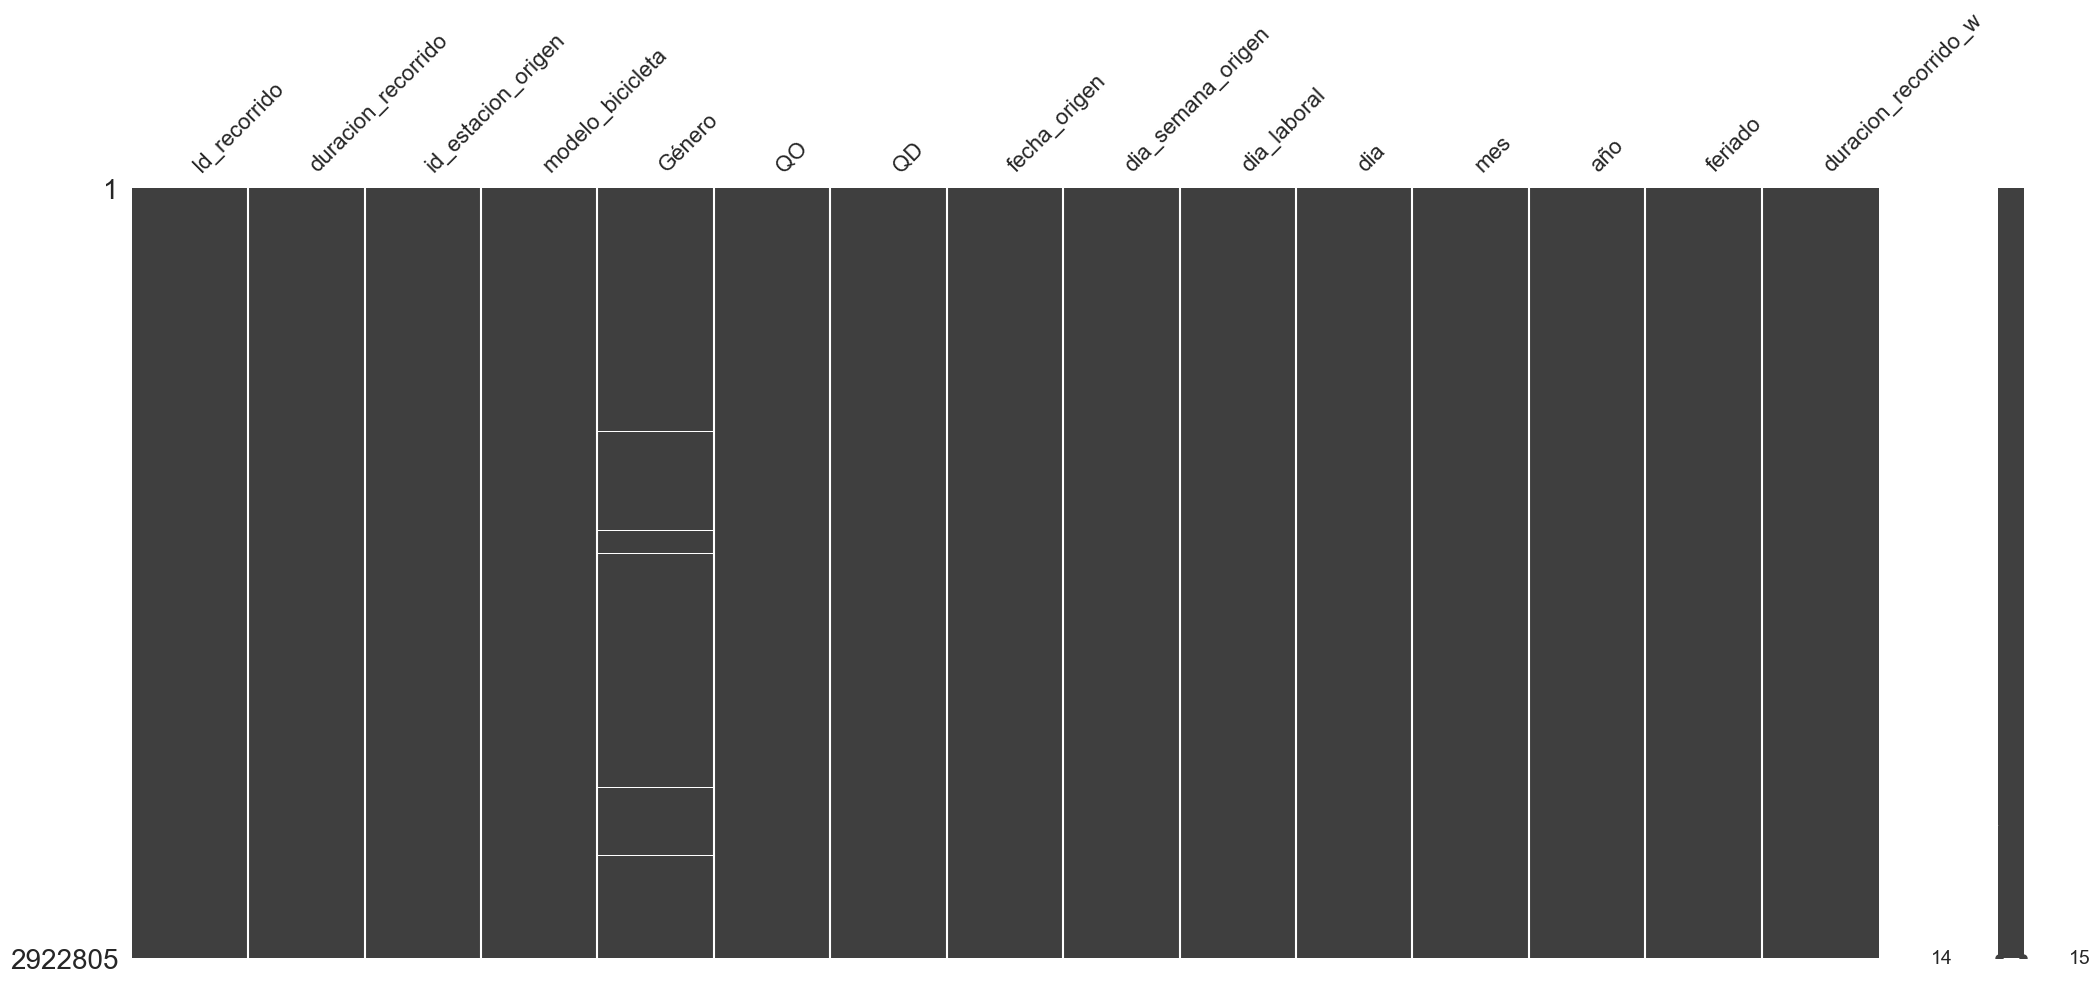

In [25]:
#Explore the data missing values
import missingno as msno
msno.matrix(data)

In [26]:
#Eliminate missing values - 0.6% of the data
data.dropna(subset=['Género'], inplace=True)

DATA ANALYSIS

In [27]:
# Convert 'Id_recorrido', 'id_estacion_origen' to integers
for col in ['Id_recorrido', 'id_estacion_origen']:
    data[col] = data[col].str.replace('BAEcobici', '').astype(int)

In [28]:
# Dividing data into numerical and categorical features
categorical_features = data.select_dtypes(include = 'object')
numerical_features = data.select_dtypes(exclude = 'object')

In [29]:
#categorical_features = categorical_features.drop(columns=['fecha_origen'])
categorical_features.sample(2)

,modelo_bicicleta,Género,QO,QD,fecha_origen
1664953,FIT,FEMALE,SE,NE,2022-08-23
1340831,FIT,MALE,SO,SO,2022-06-02


In [30]:
numerical_features.sample(2)

,Id_recorrido,duracion_recorrido,id_estacion_origen,dia_semana_origen,dia_laboral,dia,mes,año,feriado,duracion_recorrido_w
2287729,15932112,15.666667,418,4,1,13,10,2022,0,15.666667
2203100,15984583,9.416667,26,2,1,18,10,2022,0,9.416667


c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

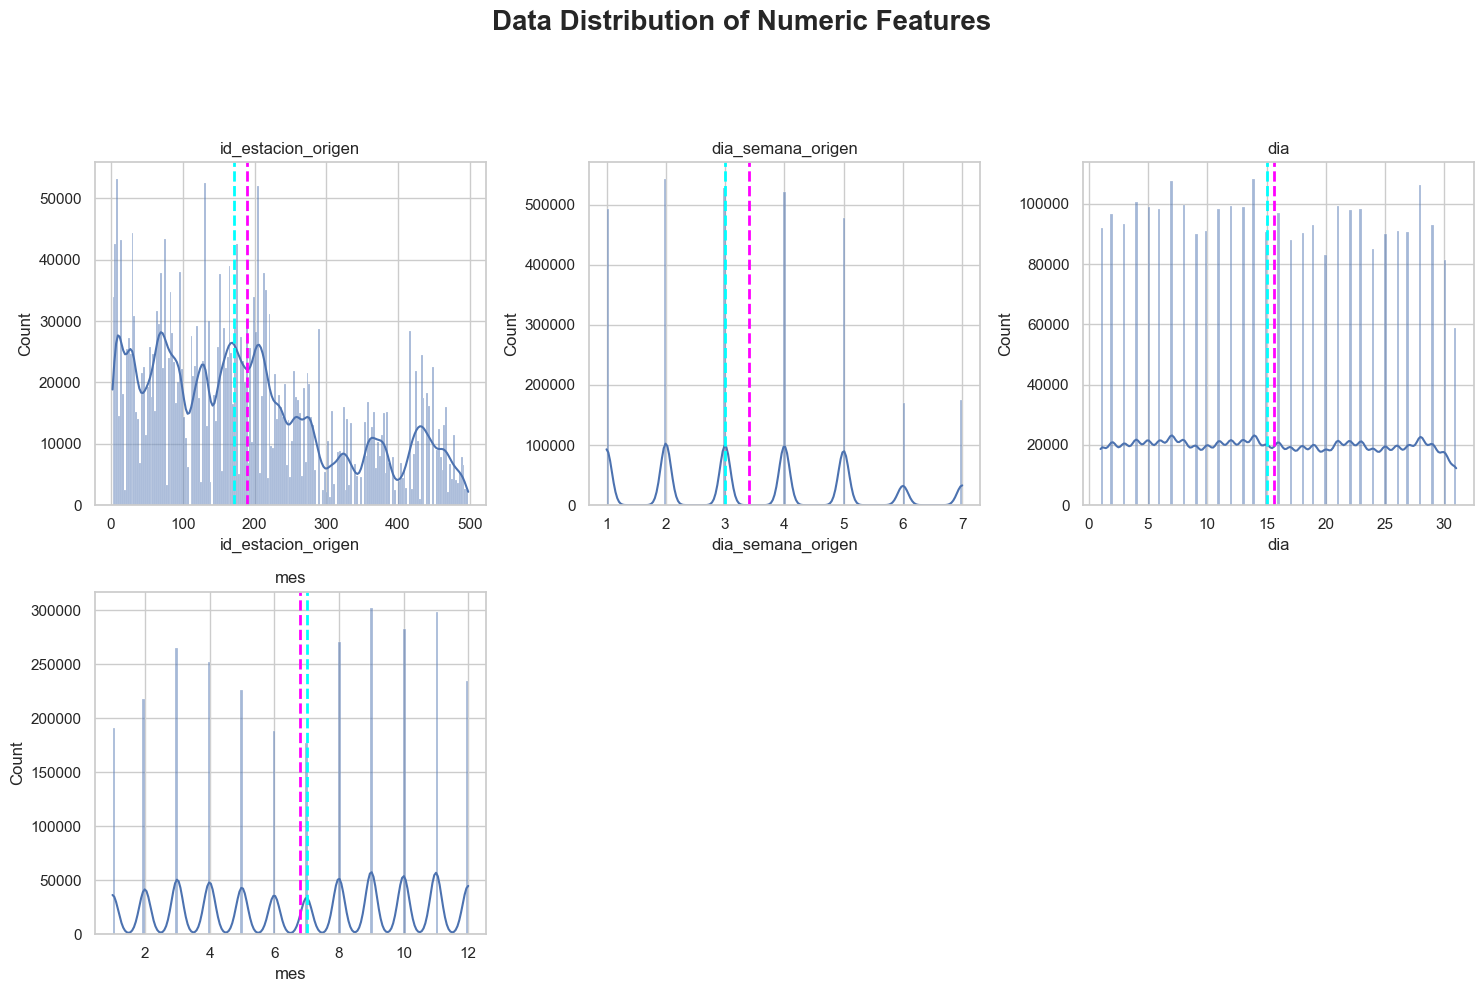

In [31]:
# Filtro features numéricas
features_to_plot = numerical_features.drop(columns=['Id_recorrido', 'dia_laboral', 'año', 'feriado', 'duracion_recorrido_w', 'duracion_recorrido'])
n_features = len(features_to_plot.columns)
ncols = 3  
nrows = int(np.ceil(n_features / ncols)) 

plt.figure(figsize=(ncols * 5, nrows * 5))
plt.suptitle('Data Distribution of Numeric Features', fontsize=20, fontweight='bold', y=1.02)

for i, col in enumerate(features_to_plot.columns):
    plt.subplot(nrows, ncols, i + 1)
    sns.histplot(features_to_plot[col], kde=True)  
    plt.axvline(features_to_plot[col].mean(), color='magenta', linestyle='dashed', linewidth=2)
    plt.axvline(features_to_plot[col].median(), color='cyan', linestyle='dashed', linewidth=2)
    plt.title(col)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Observaciones: 
-   Dias de semana concentran mas viajes y cortos. Los feriados y findes menos viajes pero mas largos. Es logico por disponibilidad.
-   El uso medio durante los dias del mes esta equilibrado.
-   Las primeras 250 estaciones concentran la mayoria de los viajes

Univariate Analysis of Categorical Features

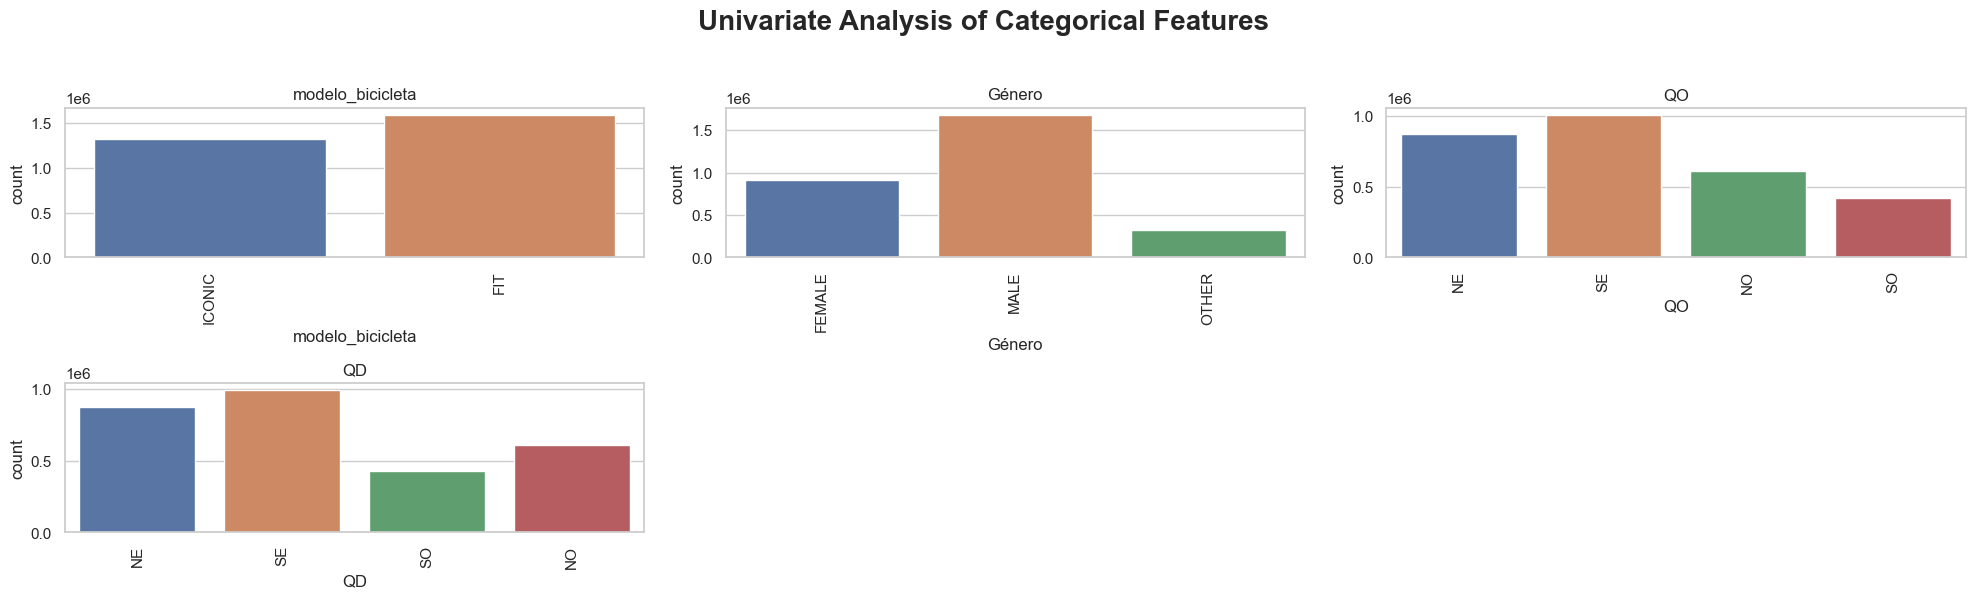

In [32]:
plt.figure(figsize = (20,8))
plt.suptitle('Univariate Analysis of Categorical Features', fontsize = 20, fontweight = 'bold', y = 1.02)

for i, col in enumerate(categorical_features.drop(columns = ['fecha_origen']).columns):
  plt.subplot(3,3, i+1)
  sns.countplot(x = categorical_features[col])
  plt.xticks(rotation ='vertical')
  plt.title(col)
  plt.tight_layout()

Observaciones: 
-   Los hombres usan mas la bicicleta que el resto.
-   El cuadrante SE es el que mas propocion de viajes inicia
-   La bicicleta tipo FIT es la mas usada --> las bicis estan repartidas por igual en las estaciones?

In [33]:
df = data.copy()

DEMANDA x CUADRANTE

In [34]:
# Contar los viajes por cuadrante y día
viajes_por_qo_dia = df.groupby(['QO', 'dia', 'mes', 'año'])['Id_recorrido'].count().reset_index()
viajes_por_qo_dia.columns = ['QO', 'dia', 'mes', 'año', 'demanda']
df = df.merge(viajes_por_qo_dia, on=['QO', 'dia', 'mes', 'año'], how='left')
# Contar el número de estaciones por cuadrante
estaciones_por_qo = df.groupby('QO')['id_estacion_origen'].nunique().reset_index()
estaciones_por_qo.columns = ['QO', 'num_estaciones']
proporciones_viajes = viajes_por_qo_dia.merge(estaciones_por_qo, on='QO')
# Unir la proporción calculada con el dataset original
df = df.merge(proporciones_viajes[['QO', 'dia', 'mes', 'año']], on=['QO', 'dia', 'mes', 'año'], how='left')

In [35]:
df = df.drop(columns=['Id_recorrido', 'id_estacion_origen', 'QD'])
df.sample(4)

,duracion_recorrido,modelo_bicicleta,Género,QO,fecha_origen,dia_semana_origen,dia_laboral,dia,mes,año,feriado,duracion_recorrido_w,demanda
778763,6.933333,ICONIC,MALE,NE,2022-04-21,4,1,21,4,2022,0,6.933333,3683
2590825,15.516667,FIT,MALE,NE,2022-11-08,2,1,8,11,2022,0,15.516667,4197
2058467,28.916667,FIT,MALE,NE,2022-09-05,1,1,5,9,2022,0,28.916667,3767
2392398,7.850000,ICONIC,FEMALE,SE,2022-11-03,4,1,3,11,2022,0,7.850000,4961


In [36]:
# One-Hot - Categorical Variables  
df = pd.get_dummies(df, columns=['modelo_bicicleta', 'Género'])
df.head(4)

,duracion_recorrido,QO,fecha_origen,dia_semana_origen,dia_laboral,dia,mes,año,feriado,duracion_recorrido_w,demanda,modelo_bicicleta_FIT,modelo_bicicleta_ICONIC,Género_FEMALE,Género_MALE,Género_OTHER
0,43.500000,NE,2022-01-16,7,0,16,1,2022,0,43.500000,599,False,True,True,False,False
1,9.083333,SE,2022-01-16,7,0,16,1,2022,0,9.083333,553,False,True,False,True,False
2,34.350000,SE,2022-01-16,7,0,16,1,2022,0,34.350000,553,False,True,True,False,False
3,212.466667,NE,2022-01-16,7,0,16,1,2022,0,86.600000,599,False,True,True,False,False


In [37]:
# Agrupar por cuadrante, día y mes, y calcular las estadísticas
grouped = df.groupby(['QO', 'dia', 'mes', 'año']).agg({
    'duracion_recorrido_w': ['mean'],
    'demanda': 'first',
    #'proporcion_viajes': 'first',
    'Género_FEMALE': 'sum',
    'Género_MALE': 'sum',
    'Género_OTHER': 'sum',
    'modelo_bicicleta_FIT': 'sum',
    'modelo_bicicleta_ICONIC': 'sum',
    'dia_laboral': 'first',  
    'fecha_origen': 'first',
    'dia_semana_origen': 'first',
    'feriado': 'first'
}).reset_index()
grouped

,QO,dia,mes,año,duracion_recorrido_w,demanda,Género_FEMALE,Género_MALE,Género_OTHER,modelo_bicicleta_FIT,modelo_bicicleta_ICONIC,dia_laboral,fecha_origen,dia_semana_origen,feriado
,,,,,mean,first,sum,sum,sum,sum,sum,first,first,first,first
0,NE,1,1,2022,30.609651,563,165,295,103,216,347,0,2022-01-01,6,1
1,NE,1,2,2022,18.579736,3025,977,1562,486,1716,1309,1,2022-02-01,2,0
2,NE,1,3,2022,27.976833,1723,561,888,274,956,767,1,2022-03-01,2,1
3,NE,1,4,2022,17.579054,3357,1019,1889,449,1707,1650,1,2022-04-01,5,0
4,NE,1,5,2022,31.083471,1091,364,595,132,549,542,0,2022-05-01,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,SO,31,5,2022,18.544904,1112,319,677,116,571,541,1,2022-05-31,2,0
1456,SO,31,7,2022,32.609439,505,192,270,43,330,175,0,2022-07-31,7,0
1457,SO,31,8,2022,19.701105,1840,595,1098,147,1174,666,1,2022-08-31,3,0


In [38]:
# Renombrar las columnas para que tengan nombres más descriptivos
grouped.columns = [
    'QO', 'dia', 'mes', 'año', 
    'duracion_recorrido_w', 'demanda', #'proporcion_viajes',
    'count_FEMALE', 'count_MALE', 'count_OTHER',
    'model_FIT', 'model_ICONIC',
    'dia_laboral', 'fecha_origen', 'dia_semana_origen', 'feriado'
]

In [39]:
# Función para calcular duración media, mínima y máxima por género
def calculate_durations_by_gender(df, gender_column):
    return df[df[gender_column]].groupby(['QO', 'dia', 'mes', 'año'])['duracion_recorrido_w'].agg(['mean'])

# Calcular las duraciones por género
duracion_media_FEMALE = calculate_durations_by_gender(df, 'Género_FEMALE').rename(columns={'mean': 'duracion_media_FEMALE'})
duracion_media_MALE = calculate_durations_by_gender(df, 'Género_MALE').rename(columns={'mean': 'duracion_media_MALE'})
duracion_media_OTHER = calculate_durations_by_gender(df, 'Género_OTHER').rename(columns={'mean': 'duracion_media_OTHER'})

# estadísticas de duración por género con el DataFrame agrupado
grouped = grouped.merge(duracion_media_FEMALE, on=['QO', 'dia', 'mes', 'año'], how='left')
grouped = grouped.merge(duracion_media_MALE, on=['QO', 'dia', 'mes', 'año'], how='left')
grouped = grouped.merge(duracion_media_OTHER, on=['QO', 'dia', 'mes', 'año'], how='left')

# columnas de proporción
grouped['prop_MALE_vs_FEMALE'] = grouped.apply(lambda row: row['count_MALE'] / row['count_FEMALE'] if row['count_FEMALE'] > 0 else float('nan'), axis=1)
grouped['prop_MALE_vs_OTHER'] = grouped.apply(lambda row: row['count_MALE'] / row['count_OTHER'] if row['count_OTHER'] > 0 else float('nan'), axis=1)
grouped['prop_FIT_vs_ICONIC'] = grouped.apply(lambda row: row['model_FIT'] / row['model_ICONIC'] if row['model_ICONIC'] > 0 else float('nan'), axis=1)

df = grouped.copy()
df = df.drop(columns=['count_FEMALE',	'count_MALE',	'count_OTHER',	'model_FIT',	'model_ICONIC'], axis=1)	
df

,QO,dia,mes,año,duracion_recorrido_w,demanda,dia_laboral,fecha_origen,dia_semana_origen,feriado,duracion_media_FEMALE,duracion_media_MALE,duracion_media_OTHER,prop_MALE_vs_FEMALE,prop_MALE_vs_OTHER,prop_FIT_vs_ICONIC
0,NE,1,1,2022,30.609651,563,0,2022-01-01,6,1,33.154646,28.754407,31.846278,1.787879,2.864078,0.622478
1,NE,1,2,2022,18.579736,3025,1,2022-02-01,2,0,19.779990,17.805111,18.656516,1.598772,3.213992,1.310924
2,NE,1,3,2022,27.976833,1723,1,2022-03-01,2,1,30.819251,26.635398,26.504562,1.582888,3.240876,1.246415
3,NE,1,4,2022,17.579054,3357,1,2022-04-01,5,0,18.861465,16.771863,18.064588,1.853778,4.207127,1.034545
4,NE,1,5,2022,31.083471,1091,0,2022-05-01,7,1,33.729853,29.154034,32.482955,1.634615,4.507576,1.012915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,SO,31,5,2022,18.544904,1112,1,2022-05-31,2,0,19.157628,18.203594,18.851868,2.122257,5.836207,1.055453
1456,SO,31,7,2022,32.609439,505,0,2022-07-31,7,0,35.523438,30.328272,33.921705,1.406250,6.279070,1.885714
1457,SO,31,8,2022,19.701105,1840,1,2022-08-31,3,0,20.730224,19.160018,19.577211,1.845378,7.469388,1.762763
1458,SO,31,10,2022,19.555200,1468,1,2022-10-31,1,0,21.267367,18.245131,22.996078,1.869748,8.725490,1.383117


c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

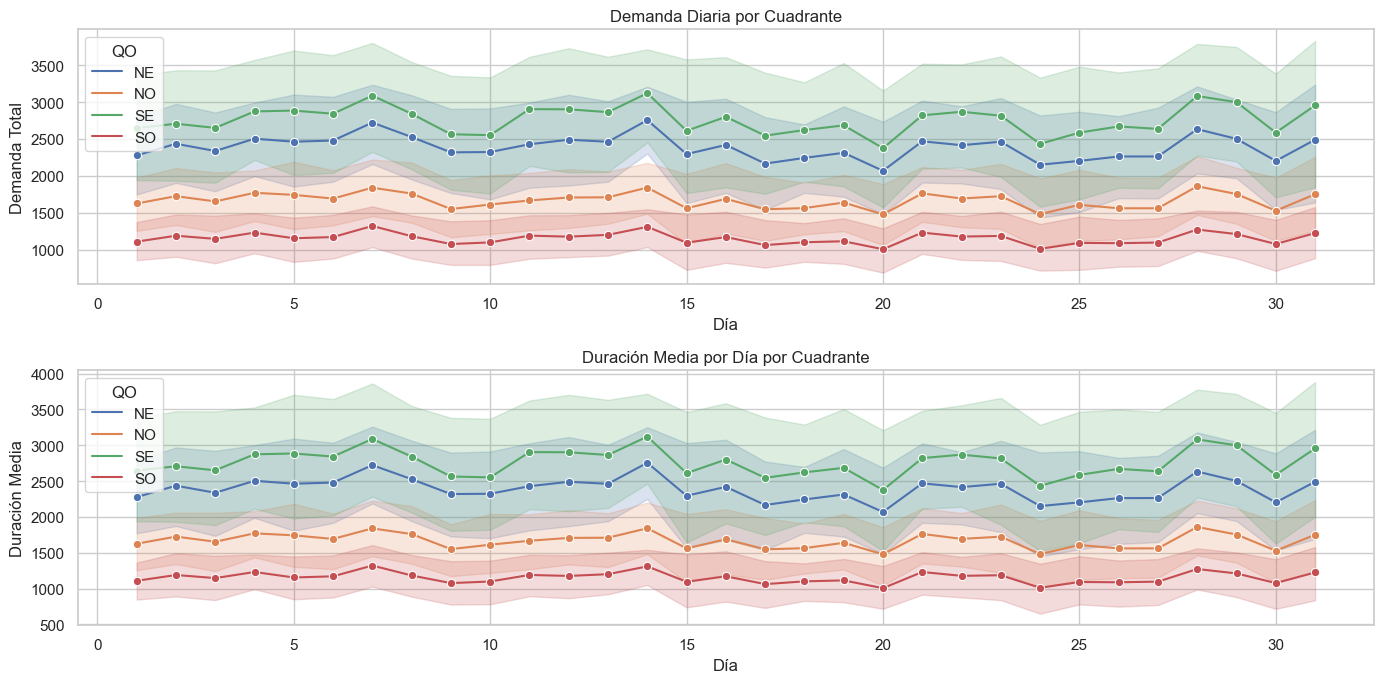

In [40]:
# Grafica demanda diaria por cuadrante y día
plt.figure(figsize=(14, 7))

# Demanda Diaria
plt.subplot(2, 1, 1)
sns.lineplot(data=df, x='dia', y='demanda', hue='QO', marker='o')
plt.title('Demanda Diaria por Cuadrante')
plt.xlabel('Día')
plt.ylabel('Demanda Total')

# Duración Media
plt.subplot(2, 1, 2)
sns.lineplot(data=df, x='dia', y='demanda', hue='QO', marker='o')
plt.title('Duración Media por Día por Cuadrante')
plt.xlabel('Día')
plt.ylabel('Duración Media')

plt.tight_layout()
plt.show()

c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


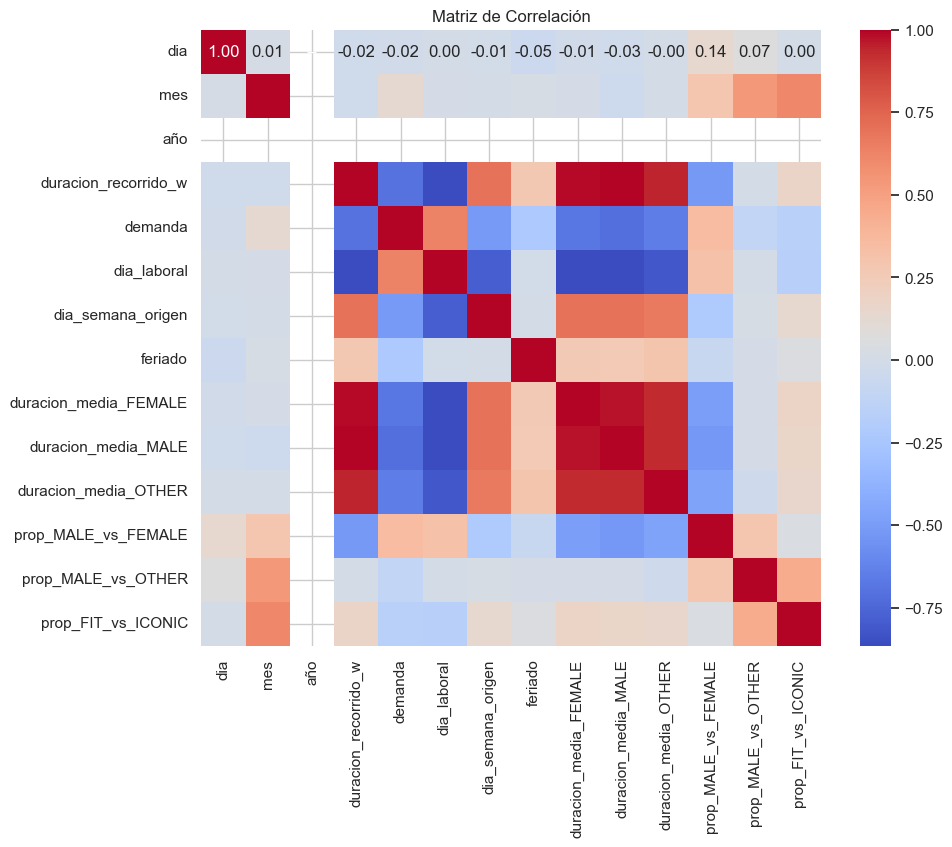

In [41]:
# Mapa de calor para la matriz de correlación
plt.figure(figsize=(10, 8))
numerical_features = df.select_dtypes(exclude = 'object')
matriz_correlacion = numerical_features.corr()
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

In [42]:
#ANALISIS SOBRE CUADRANTE SE QUE TIENE MAS AFLUENCIA DE USUARIOS
df_SE = df[df['QO'] == 'SE'].copy()
df_SE = df_SE.drop(columns=['QO'])
# Crear la columna 'fecha' combinando 'año', 'mes' y 'dia'
df_SE

,dia,mes,año,duracion_recorrido_w,demanda,dia_laboral,fecha_origen,dia_semana_origen,feriado,duracion_media_FEMALE,duracion_media_MALE,duracion_media_OTHER,prop_MALE_vs_FEMALE,prop_MALE_vs_OTHER,prop_FIT_vs_ICONIC
730,1,1,2022,27.426187,688,0,2022-01-01,6,1,27.160294,26.919162,29.955035,1.487395,3.687500,0.746193
731,1,2,2022,18.544753,3497,1,2022-02-01,2,0,20.227040,17.386205,19.345925,1.699301,4.753056,1.282637
732,1,3,2022,27.273892,1331,1,2022-03-01,2,1,31.408707,25.558368,23.546708,1.621076,4.462963,1.116057
733,1,4,2022,16.963464,3788,1,2022-04-01,5,0,17.648427,16.403683,17.968764,1.922203,4.941573,1.022424
734,1,5,2022,30.941286,897,0,2022-05-01,7,1,31.261614,30.713669,31.164744,1.763066,4.865385,1.020270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,31,5,2022,16.057022,3012,1,2022-05-31,2,0,17.244095,15.264790,17.573378,2.163170,6.228188,0.950777
1091,31,7,2022,31.048073,917,0,2022-07-31,7,0,32.673538,29.810923,32.078889,1.544615,5.577778,1.635057
1092,31,8,2022,16.987141,4412,1,2022-08-31,3,0,18.232556,16.209521,18.156741,2.064985,6.702233,1.282462
1093,31,10,2022,16.374685,4078,1,2022-10-31,1,0,17.269197,15.812784,17.294293,2.094245,6.823370,1.391789


MODELO - SARIMAX

c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\bdomecq\AppData\Local\anaco

Best RMSE: 832.0189265585103
Best Params: {'D': 1, 'P': 1, 'Q': 1, 'd': 0, 'p': 1, 'q': 1, 's': 7}


c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


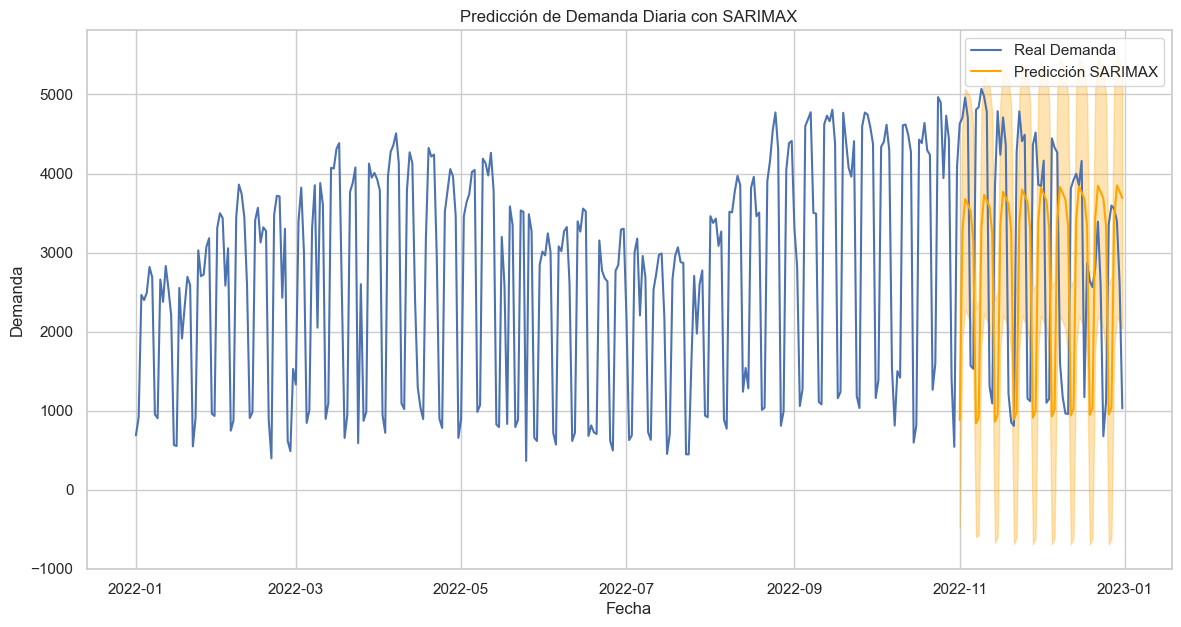

In [43]:
# Preprocesar los datos
df_SE.set_index('fecha_origen', inplace=True)
df_SE = df_SE.asfreq('D')

# Separar en entrenamiento y prueba
train = df_SE.loc[:'2022-10-30']
test = df_SE.loc['2022-11-01':]

# Model tuning
param_grid = {
    'p': [0, 1, 2],
    'd': [0, 1],
    'q': [0, 1, 2],
    'P': [0, 1],
    'D': [0, 1],
    'Q': [0, 1],
    's': [7, 30]  # Weekly or Monthly seasonality
}

# Grid search
best_rmse = float('inf')
best_params = None

for params in ParameterGrid(param_grid):
    try:
        model = SARIMAX(
            train['demanda'],
            order=(params['p'], params['d'], params['q']),
            seasonal_order=(params['P'], params['D'], params['Q'], params['s']),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)
        pred = results.predict(start=test.index[0], end=test.index[-1])
        rmse = np.sqrt(mean_squared_error(test['demanda'], pred))
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
    except Exception as e:
        print(f"Skipping params {params} due to error: {e}")

print(f'Best RMSE: {best_rmse}')
print(f'Best Params: {best_params}')

# Fit model with best parameters
model = SARIMAX(
    df_SE['demanda'],
    order=(best_params['p'], best_params['d'], best_params['q']),
    seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], best_params['s']),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)

# Forecast
forecast = results.get_forecast(steps=len(test))
forecast_index = pd.date_range(start=test.index[0], end=test.index[-1], freq='D')
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(df_SE.index, df_SE['demanda'], label='Real Demanda')
plt.plot(test.index, forecast_mean, label='Predicción SARIMAX', color='orange')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='orange', alpha=0.3)
plt.title('Predicción de Demanda Diaria con SARIMAX')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()


MODELO - PROPHET

In [44]:
#ANALISIS SOBRE CUADRANTE SE QUE TIENE MAS AFLUENCIA DE USUARIOS
df_SE = df[df['QO'] == 'SE'].copy()
df_SE = df_SE.drop(columns=['QO'])

In [45]:
#Split into Train and Test
train_indices = df_SE.fecha_origen.apply(lambda x: x.month) < 10 # 80% train menores a nobiembre 2022
df_train = df_SE.loc[train_indices].dropna()
df_test = df_SE.loc[~train_indices].reset_index(drop=True)
df_train.rename(columns={'fecha_origen': 'ds', 'demanda': 'y'}, inplace=True)
df_test.rename(columns={'fecha_origen': 'ds', 'demanda': 'y'}, inplace=True)

In [46]:
#Create Model
model_prophet = Prophet(seasonality_mode='additive')
model_prophet.add_seasonality(name='monthly', period=30.5,fourier_order=5)

In [47]:
model_prophet.fit(df_train)

02:13:09 - cmdstanpy - INFO - Chain [1] start processing
02:13:09 - cmdstanpy - INFO - Chain [1] done processing


c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


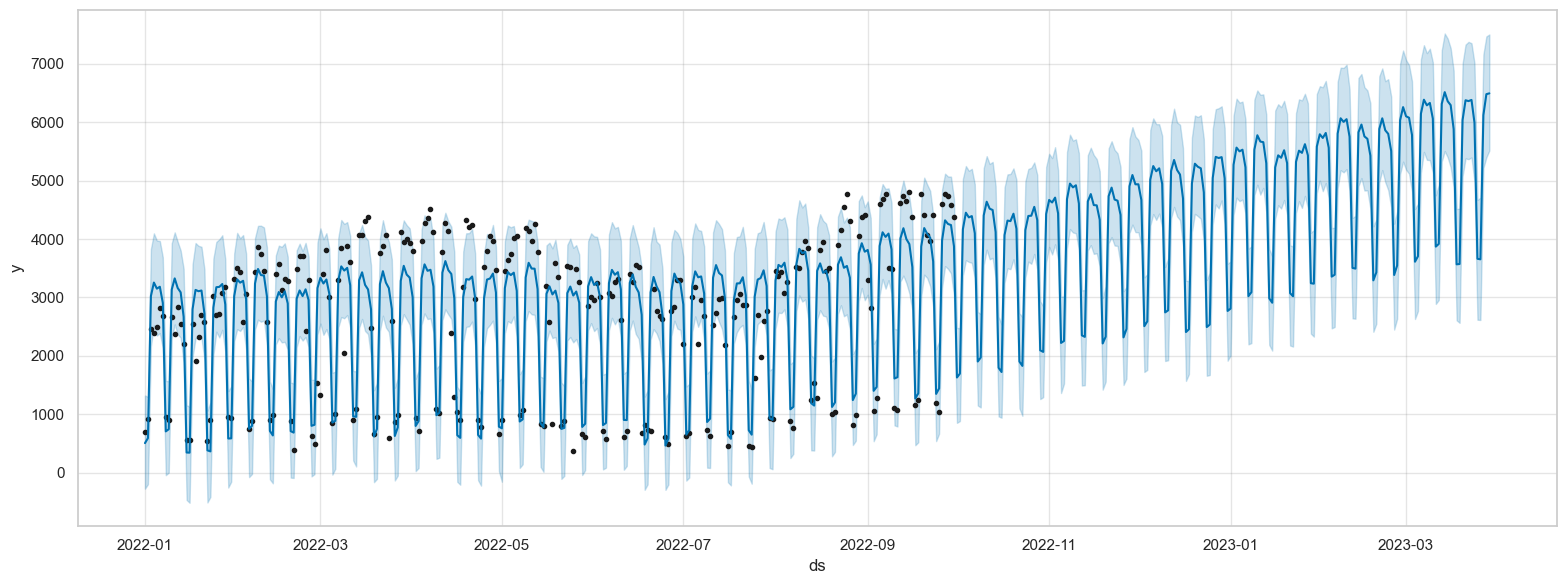

In [48]:
df_future = model_prophet.make_future_dataframe(periods=180)
df_pred = model_prophet.predict(df_future)
fig=model_prophet.plot(df_pred)
fig.set_size_inches(16.5, 6)

c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

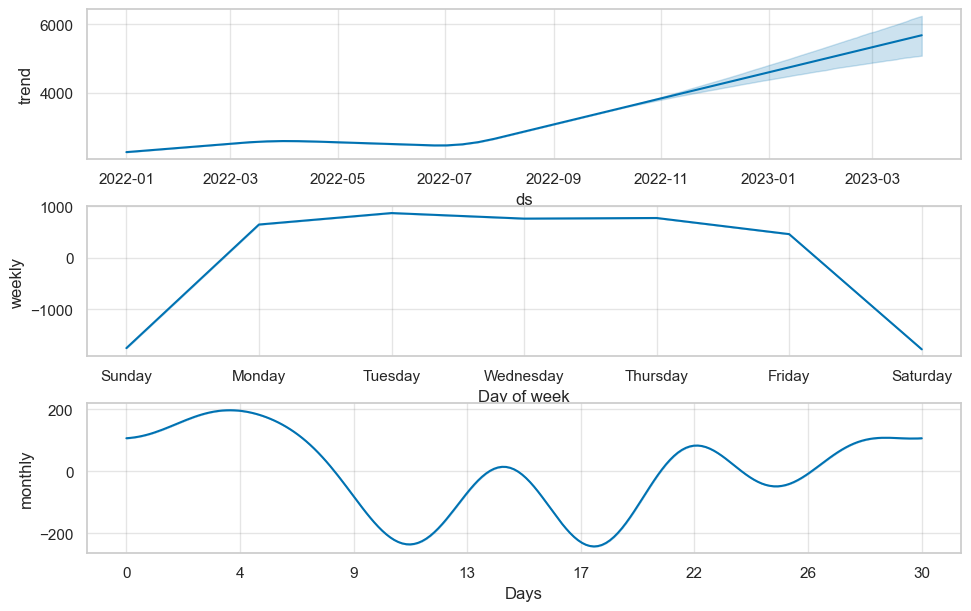

In [49]:
#Decomponemos el modelo
fig=model_prophet.plot_components(df_pred)
fig.set_size_inches(10, 6)

In [56]:
#Merge datasets preparacion
selected_columns = ['ds', 'yhat_lower', 'yhat_upper', 'yhat']
df_pred = df_pred.loc[:, selected_columns].reset_index(drop=True)
df_pred

,ds,yhat_lower,yhat_upper,yhat
0,2022-01-01,-275.275143,1320.735170,505.511317
1,2022-01-02,-198.588054,1299.552796,590.879121
2,2022-01-03,2162.270390,3832.475351,3025.491633
3,2022-01-04,2523.248939,4098.703955,3255.510636
4,2022-01-05,2346.621209,3975.846702,3151.133168
...,...,...,...,...
448,2023-03-25,2618.961575,4669.687962,3662.891787
449,2023-03-26,2614.435019,4709.182083,3653.550772
450,2023-03-27,5219.078328,7163.530166,6123.090654
451,2023-03-28,5399.564973,7471.137960,6482.206774


In [ ]:
#Merge datasets
# Convertir 'ds' en ambos DataFrames a datetime
df_test['ds'] = pd.to_datetime(df_test['ds'])
df_pred['ds'] = pd.to_datetime(df_pred['ds'])
# Hacer el merge
df_test = df_test.merge(df_pred, on='ds', how='left')
# Establecer 'ds' como índice
df_test.set_index('ds', inplace=True)


c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


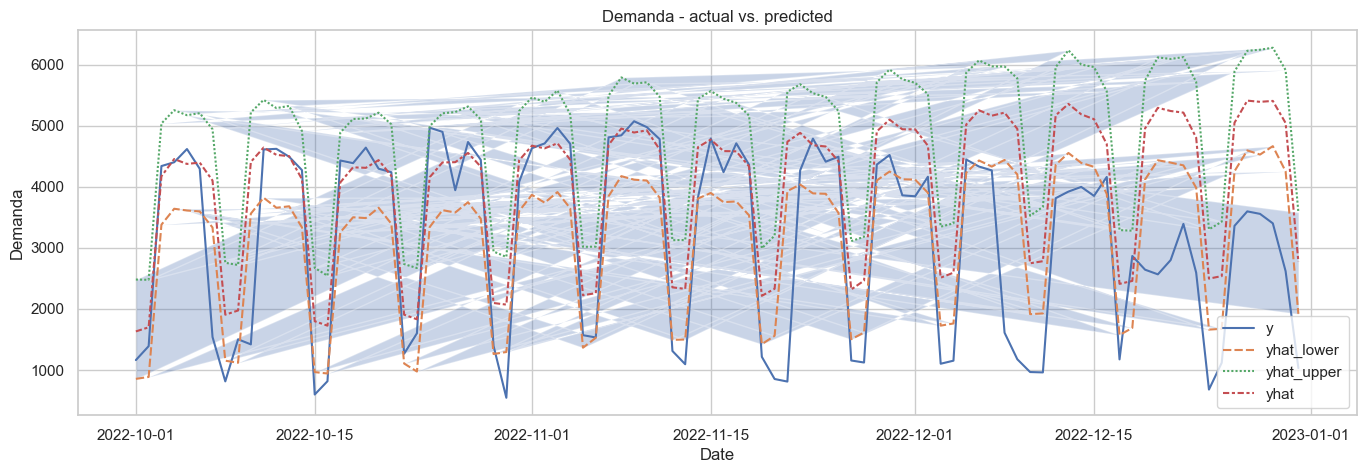

In [62]:
#Graficamos
fig, ax = plt.subplots(1, 1)
ax = sns.lineplot(data=df_test[['y', 'yhat_lower', 'yhat_upper', 'yhat']])
ax.fill_between(df_test.index, df_test.yhat_lower,
df_test.yhat_upper,
alpha=0.3)
ax.set(title='Demanda - actual vs. predicted',
xlabel='Date', ylabel='Demanda')
fig.set_size_inches(16.5, 5)

In [60]:
rmse = np.sqrt(mean_squared_error(df_test['y'], df_test['yhat']))
print(f'RMSE: {rmse}')

RMSE: 1310.0562054239233


AÑADIDO DEL CLIMA POR DIA

In [65]:
#MERGE CLIMA Y BICIS
file_path = '../src/data/clima_bsas_2022.csv'
clima_2022 = pd.read_csv(file_path)
clima_2022

,tavg,tmin,tmax,prcp,wdir,wspd,pres,dia,mes,año
0,24.9,21.1,33.5,0.0,312,7.0,1003.9,1,1,2022
1,26.6,19.7,32.7,0.0,323,5.5,1004.9,2,1,2022
2,29.7,24.3,35.7,0.0,24,9.4,1006.7,3,1,2022
3,28.8,22.4,35.8,0.0,194,14.6,1005.8,4,1,2022
4,21.9,16.0,32.0,0.0,62,19.2,1015.4,5,1,2022
...,...,...,...,...,...,...,...,...,...,...
360,25.8,19.6,30.9,0.0,331,7.0,1011.2,27,12,2022
361,26.6,22.3,31.1,0.0,181,10.0,1009.8,28,12,2022
362,23.9,16.1,31.0,0.0,342,5.9,1013.7,29,12,2022
363,29.1,21.8,36.6,0.0,321,11.4,1008.9,30,12,2022


In [66]:
# CUADRANTE CON MAYOR AFLUENCIA DE USUARIOS
df_SE = df[df['QO'] == 'SE'].copy()
df_SE = df_SE.drop(columns=['QO'])

In [67]:
# Unir los DataFrames usando 'día' y 'mes' como claves
merged_df = pd.merge(df_SE, clima_2022, how='left', on=['dia', 'mes', 'año'])
merged_df

,dia,mes,año,duracion_recorrido_w,demanda,dia_laboral,fecha_origen,dia_semana_origen,feriado,duracion_media_FEMALE,duracion_media_MALE,duracion_media_OTHER,prop_MALE_vs_FEMALE,prop_MALE_vs_OTHER,prop_FIT_vs_ICONIC,tavg,tmin,tmax,prcp,wdir,wspd,pres
0,1,1,2022,27.426187,688,0,2022-01-01,6,1,27.160294,26.919162,29.955035,1.487395,3.687500,0.746193,24.9,21.1,33.5,0.0,312,7.0,1003.9
1,1,2,2022,18.544753,3497,1,2022-02-01,2,0,20.227040,17.386205,19.345925,1.699301,4.753056,1.282637,23.5,18.8,28.3,0.0,352,11.3,1011.8
2,1,3,2022,27.273892,1331,1,2022-03-01,2,1,31.408707,25.558368,23.546708,1.621076,4.462963,1.116057,21.6,14.6,29.7,0.0,336,10.4,1013.2
3,1,4,2022,16.963464,3788,1,2022-04-01,5,0,17.648427,16.403683,17.968764,1.922203,4.941573,1.022424,14.5,8.2,21.2,0.0,351,3.6,1026.2
4,1,5,2022,30.941286,897,0,2022-05-01,7,1,31.261614,30.713669,31.164744,1.763066,4.865385,1.020270,13.8,7.9,19.9,0.0,140,6.1,1017.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,31,5,2022,16.057022,3012,1,2022-05-31,2,0,17.244095,15.264790,17.573378,2.163170,6.228188,0.950777,6.4,1.2,13.2,0.0,235,2.9,1022.4
361,31,7,2022,31.048073,917,0,2022-07-31,7,0,32.673538,29.810923,32.078889,1.544615,5.577778,1.635057,14.6,10.3,20.5,0.0,356,4.7,1018.2
362,31,8,2022,16.987141,4412,1,2022-08-31,3,0,18.232556,16.209521,18.156741,2.064985,6.702233,1.282462,16.6,13.6,20.4,0.0,12,6.5,1017.1
363,31,10,2022,16.374685,4078,1,2022-10-31,1,0,17.269197,15.812784,17.294293,2.094245,6.823370,1.391789,12.9,7.9,17.7,0.0,156,12.0,1027.5


In [68]:
# Dividing data into numerical and categorical features
categorical_features = merged_df.select_dtypes(include = 'object')
numerical_features = merged_df.select_dtypes(exclude = 'object')

Se usan mas la bicis cuando la temperatura es agradable

C:\Users\bdomecq\AppData\Local\Temp\ipykernel_23888\1946107567.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mydata_w['temp_round'] = mydata_w['tavg']//bin_size
C:\Users\bdomecq\AppData\Local\Temp\ipykernel_23888\1946107567.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mydata_nw['temp_round'] = mydata_nw['tavg']//bin_size


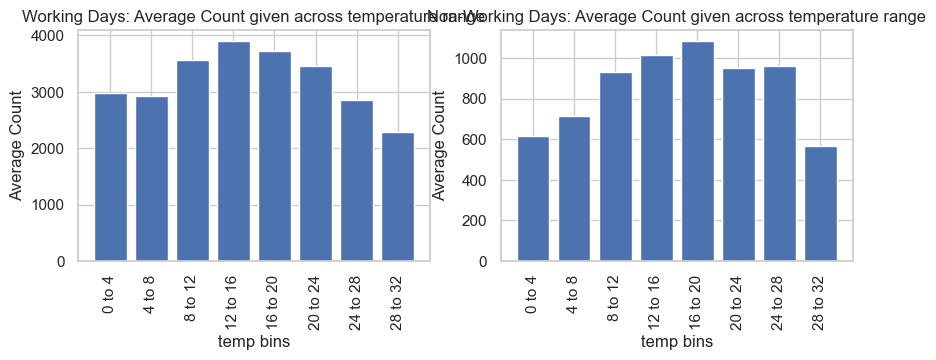

In [69]:
# Splitting data into working-day and non-working day
mydata_w = numerical_features[numerical_features.dia_laboral==1]
mydata_nw = numerical_features[numerical_features.dia_laboral==0]

bin_size = 4
mydata_w['temp_round'] = mydata_w['tavg']//bin_size
mydata_nw['temp_round'] = mydata_nw['tavg']//bin_size

mean_count_vs_temp_w = mydata_w.groupby('temp_round')['demanda'].mean()
mean_count_vs_temp_nw = mydata_nw.groupby('temp_round')['demanda'].mean()
idx_w, idx_nw = range(len(mean_count_vs_temp_w)), range(len(mean_count_vs_temp_nw))
labels_w = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_w))]
labels_nw = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_nw))]

fig = plt.figure(figsize=(10, 3))
axes = fig.add_subplot(1, 2, 1)
plt.bar(x=idx_w, height=mean_count_vs_temp_w)
plt.xticks(idx_w, labels_w, rotation=90)
plt.xlabel('temp bins')
plt.ylabel('Average Count')
plt.title('Working Days: Average Count given across temperature range')

axes = fig.add_subplot(1, 2, 2)
plt.bar(x=idx_nw, height=mean_count_vs_temp_nw)
plt.xticks(idx_nw, labels_nw, rotation=90)
plt.xlabel('temp bins')
plt.ylabel('Average Count')
plt.title('Non-Working Days: Average Count given across temperature range')

plt.show()

c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


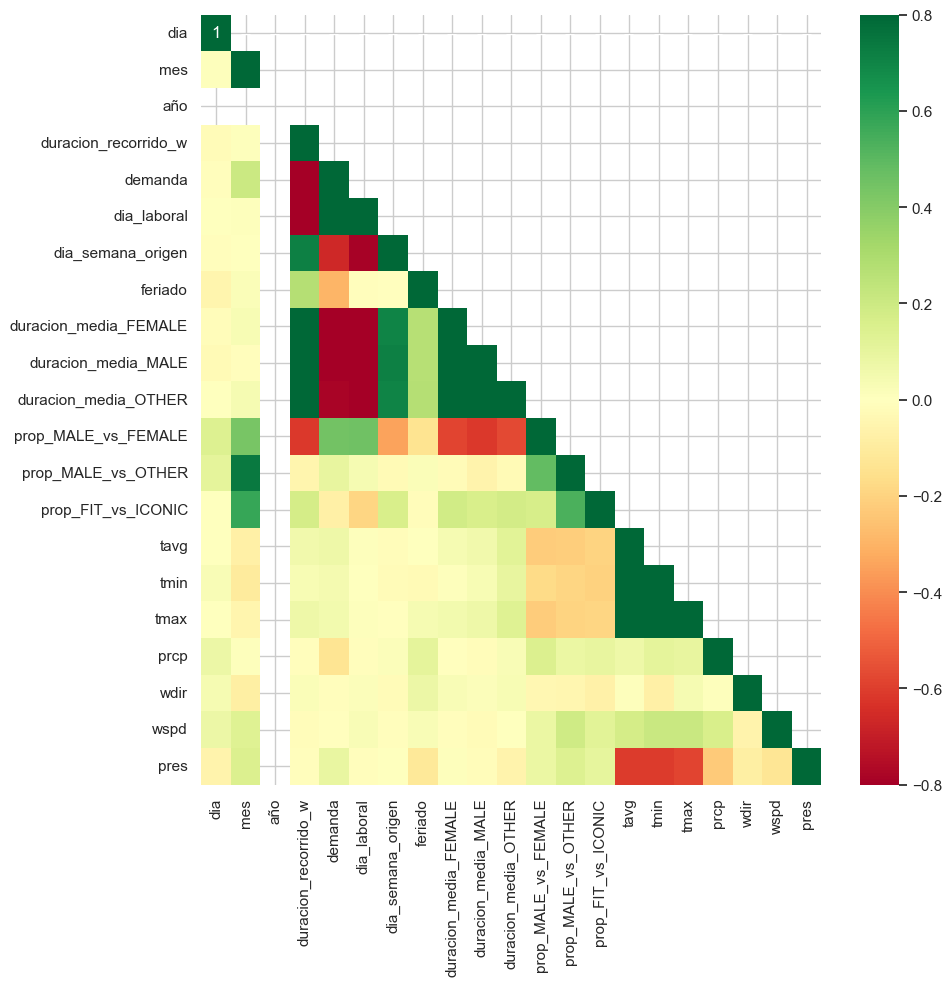

In [70]:
# Heatmap relative to all numeric columns
corr_matrix = numerical_features.corr()
mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False
fig = plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, mask=mask, annot=True, cbar=True, vmax=0.8, vmin=-0.8, cmap='RdYlGn')
plt.show()

MODELADO - LR/RF/XGB

C:\Users\bdomecq\AppData\Local\Temp\ipykernel_23888\2671623606.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((merged_df['demanda']),ax=axes[0],color='brown').set_title(" Input data");
c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\bdomecq\AppData\Local\Temp\ipykernel_23888\2671623606.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt yo

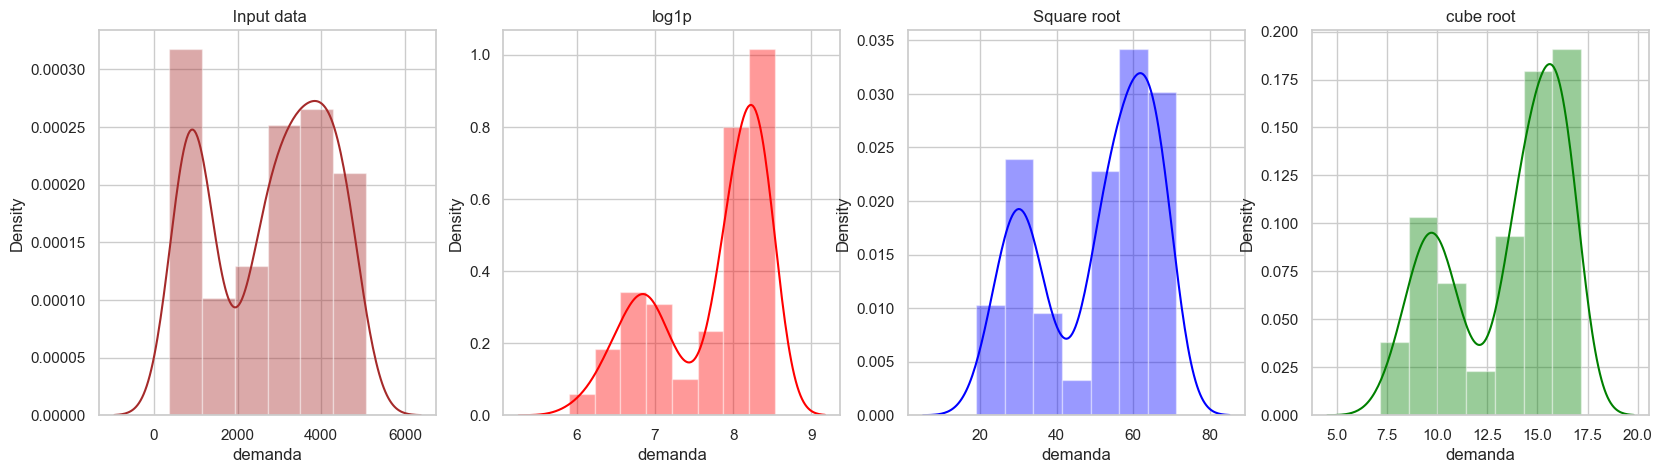

In [71]:
#apply diffrent tranformation technique and checking data distributation
fig,axes = plt.subplots(1,4,figsize=(20,5))
sns.distplot((merged_df['demanda']),ax=axes[0],color='brown').set_title(" Input data");

# here we use log10
#transform only posible in positive value and >0 value so add 0.0000001 in data
sns.distplot(np.log1p(merged_df['demanda']),ax=axes[1],color='red').set_title("log1p");

# here we use square root
sns.distplot(np.sqrt(merged_df['demanda']),ax=axes[2], color='blue').set_title("Square root");

# here we use cube root
sns.distplot(np.cbrt(merged_df['demanda']),ax=axes[3], color='green').set_title("cube root");

C:\Users\bdomecq\AppData\Local\Temp\ipykernel_23888\247772081.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  dist =sns.distplot(np.sqrt(merged_df['demanda']), ax = ax[0])
c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


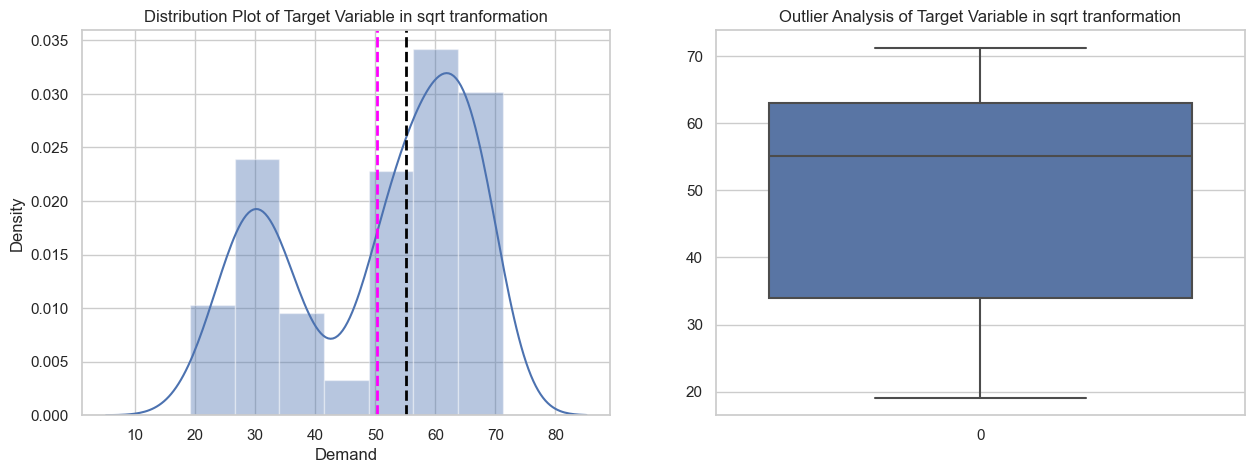

In [72]:
fig, ax = plt.subplots(1,2 , figsize = (15,5))
#  checking square root tranformation in our target variable
dist =sns.distplot(np.sqrt(merged_df['demanda']), ax = ax[0])
dist.set(xlabel = 'Demand', ylabel ='Density', title = 'Distribution Plot of Target Variable in sqrt tranformation')
# mean line
dist.axvline(np.sqrt(merged_df['demanda']).mean(), color='magenta', linestyle='dashed', linewidth=2)
# median line
dist.axvline(np.sqrt(merged_df['demanda']).median(), color='black', linestyle='dashed', linewidth=2)
# Boxplot
box = sns.boxplot(np.sqrt(merged_df['demanda']), ax= ax[1])
box.set(title = 'Outlier Analysis of Target Variable in sqrt tranformation')
plt.show()

MODELOS - CON CLIMA - NORMALIZANDO - CORTANDO 80 - 20

In [74]:
merged_df = merged_df.drop(columns=['fecha_origen'])

In [75]:
# applying square root on Demanda
merged_df['demanda']=np.sqrt(merged_df['demanda'])

In [76]:
# SPLIT DATA
df = merged_df.sort_values(by=['año', 'mes', 'dia'])

# Filtrar datos de entrenamiento y prueba por el día del mes
train_mask = df['dia'] <= 25
test_mask = df['dia'] > 25

# Dividir en conjuntos de entrenamiento y prueba
df_train = df[train_mask]
df_test = df[test_mask]

# Separar características (X) y variable objetivo (y) para entrenamiento y prueba
X_train = df_train.drop(['demanda'], axis=1)
y_train = df_train['demanda']
X_test = df_test.drop(['demanda'], axis=1)
y_test = df_test['demanda']

print("Conjunto de entrenamiento:")
print(X_train.shape)
print("Conjunto de prueba:")
print(X_test.shape)

Conjunto de entrenamiento:
(300, 20)
Conjunto de prueba:
(65, 20)


In [77]:
# SCALADO DE DATOS
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [78]:
# empty list for appending performance metric score
model_result = []

def predict(ml_model,model_name):

  '''
  Pass the model and predict value.
  Function will calculate all the evaluation metrics and appending those metrics score on model_result list.
  Plotting different graphs for test data.
  '''

  # model fitting
  model = ml_model.fit(X_train,y_train)

  # predicting values
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  # Reverse the transformation on the predictions    
  y_train_pred_original = np.power(y_train_pred, 2)
  y_test_pred_original = np.power(y_test_pred, 2)

  # graph --> best fit line on test data
  sns.regplot(x=y_test_pred, y=y_test, line_kws={'color':'red'})
  plt.xlabel('Predicted')
  plt.ylabel('Actual')

  '''Evaluation metrics on train data'''
  train_MSE  = round(mean_squared_error(y_train, y_train_pred),3)
  train_RMSE = round(np.sqrt(train_MSE),3)
  train_r2 = round(r2_score(y_train, y_train_pred),3)
  train_MAE = round(mean_absolute_error(y_train, y_train_pred),3)
  train_adj_r2 = round(1-(1-r2_score(y_train, y_train_pred))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)),3)
  print(f'train MSE : {train_MSE}')
  print(f'train RMSE : {train_RMSE}')
  print(f'train MAE : {train_MAE}')
  print(f'train R2 : {train_r2}')
  print(f'train Adj R2 : {train_adj_r2}')
  print('-'*150)

  '''Evaluation metrics on test data'''
  test_MSE  = round(mean_squared_error(y_test, y_test_pred),3)
  test_RMSE = round(np.sqrt(test_MSE),3)
  test_r2 = round(r2_score(y_test, y_test_pred),3)
  test_MAE = round(mean_absolute_error(y_test, y_test_pred),3)
  test_adj_r2 = round(1-(1-r2_score(y_test, y_test_pred))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)),3)
  print(f'test MSE : {test_MSE}')
  print(f'test RMSE : {test_RMSE}')
  print(f'test MAE : {test_MAE}')
  print(f'test R2 : {test_r2}')
  print(f'test Adj R2 : {test_adj_r2}')
  print('-'*150)

  # graph --> actual vs predicted on test data
  plt.figure(figsize=(6,5))
  plt.plot((y_test_pred))
  plt.plot(np.array((y_test)))
  plt.legend(["Predicted","Actual"])
  plt.xlabel('Test Data Points')
  plt.show()
  print('-'*150)

  '''actual vs predicted value on test data'''
  d = {'y_actual':y_test, 'y_predict':y_test_pred, 'error':y_test-y_test_pred}
  print(pd.DataFrame(data=d).head().T)
  print('-'*150)

  # using the score from the performance metrics to create the final model_result.
  model_result.append({'model':model_name,
                       'train MSE':train_MSE,
                       'test MSE':test_MSE,
                       'train RMSE':train_RMSE,
                       'test RMSE':test_RMSE,
                       'train MAE':train_MAE,
                       'test MAE':test_MAE,
                       'train R2':train_r2,
                       'test R2':test_r2,
                       'train Adj R2':train_adj_r2,
                       'test Adj R2':test_adj_r2})

train MSE : 25.241
train RMSE : 5.024
train MAE : 4.024
train R2 : 0.889
train Adj R2 : 0.881
------------------------------------------------------------------------------------------------------------------------------------------------------
test MSE : 32.089
test RMSE : 5.665
test MAE : 4.504
test R2 : 0.863
test Adj R2 : 0.801
------------------------------------------------------------------------------------------------------------------------------------------------------


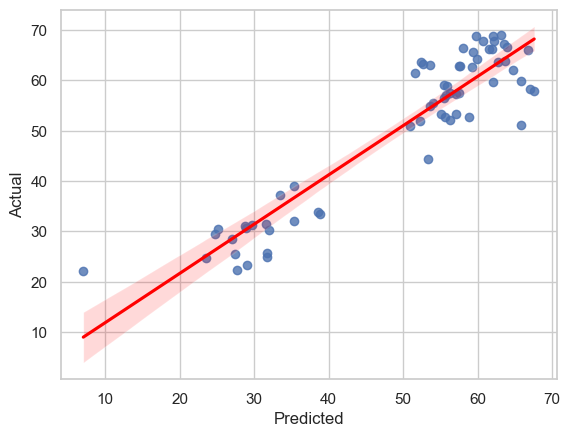

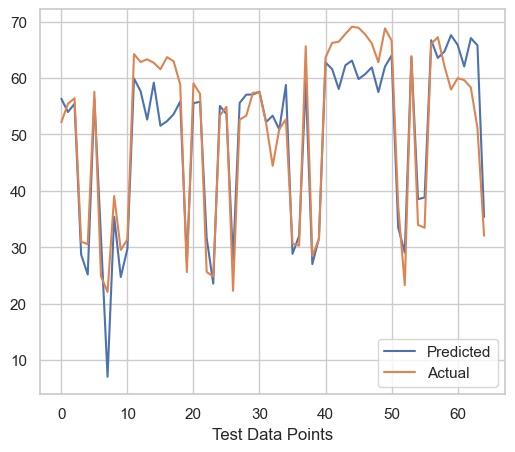

------------------------------------------------------------------------------------------------------------------------------------------------------
                 300        312        324        336        347
y_actual   52.172790  55.434646  56.400355  31.000000  30.545049
y_predict  56.321392  53.968369  55.433748  28.701613  25.175719
error      -4.148602   1.466277   0.966607   2.298387   5.369329
------------------------------------------------------------------------------------------------------------------------------------------------------


In [79]:
predict(LinearRegression(), 'LinearRegression')

train MSE : 27.437
train RMSE : 5.238
train MAE : 4.286
train R2 : 0.879
train Adj R2 : 0.87
------------------------------------------------------------------------------------------------------------------------------------------------------
test MSE : 35.393
test RMSE : 5.949
test MAE : 4.852
test R2 : 0.849
test Adj R2 : 0.78
------------------------------------------------------------------------------------------------------------------------------------------------------


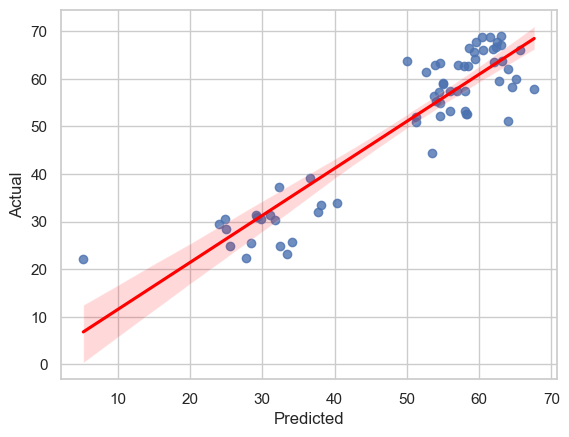

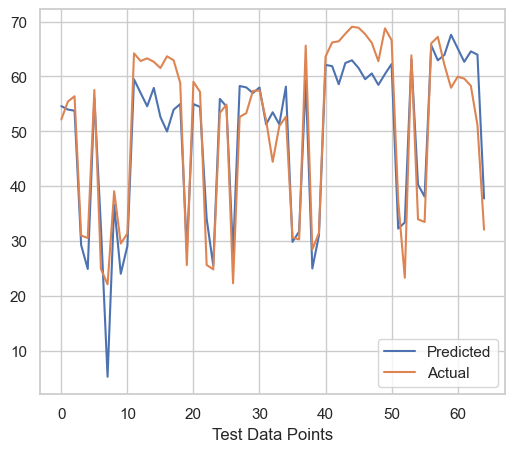

------------------------------------------------------------------------------------------------------------------------------------------------------
                 300        312        324        336        347
y_actual   52.172790  55.434646  56.400355  31.000000  30.545049
y_predict  54.598356  53.971412  53.763785  29.262334  24.896540
error      -2.425566   1.463234   2.636570   1.737666   5.648509
------------------------------------------------------------------------------------------------------------------------------------------------------


In [80]:
predict(ElasticNet(alpha=0.1, max_iter=1000), 'Elastic Net')

train MSE : 0.534
train RMSE : 0.731
train MAE : 0.315
train R2 : 0.998
train Adj R2 : 0.997
------------------------------------------------------------------------------------------------------------------------------------------------------
test MSE : 32.413
test RMSE : 5.693
test MAE : 4.462
test R2 : 0.861
test Adj R2 : 0.799
------------------------------------------------------------------------------------------------------------------------------------------------------


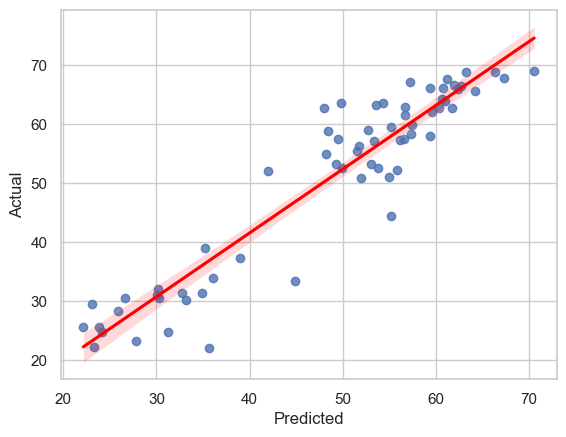

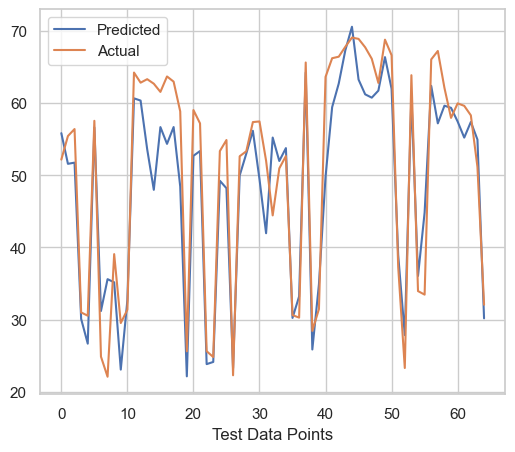

------------------------------------------------------------------------------------------------------------------------------------------------------
                 300        312        324        336        347
y_actual   52.172790  55.434646  56.400355  31.000000  30.545049
y_predict  55.827881  51.583180  51.749201  30.101666  26.677890
error      -3.655091   3.851466   4.651153   0.898334   3.867158
------------------------------------------------------------------------------------------------------------------------------------------------------


In [81]:
predict(SVR(kernel='rbf',C=100), 'SVM')

train MSE : 16.476
train RMSE : 4.059
train MAE : 3.113
train R2 : 0.927
train Adj R2 : 0.922
------------------------------------------------------------------------------------------------------------------------------------------------------
test MSE : 29.736
test RMSE : 5.453
test MAE : 4.46
test R2 : 0.873
test Adj R2 : 0.815
------------------------------------------------------------------------------------------------------------------------------------------------------


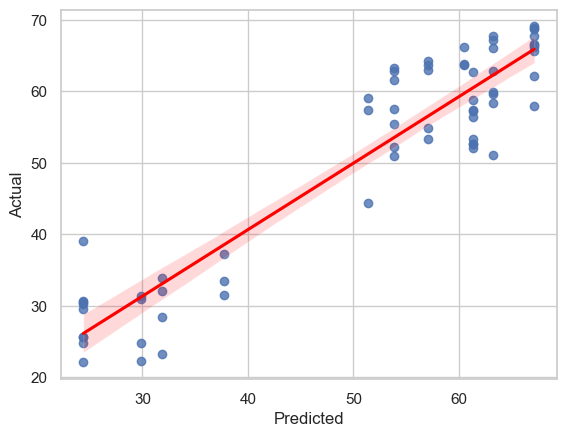

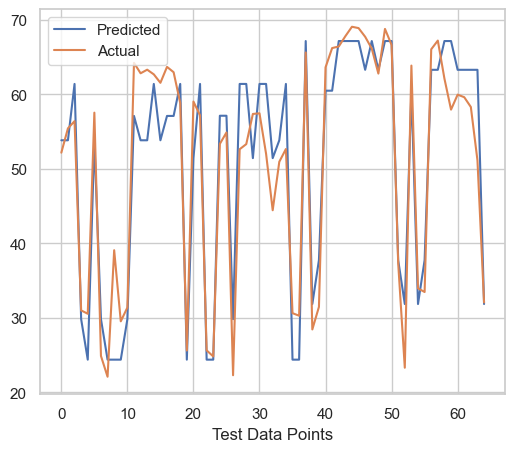

------------------------------------------------------------------------------------------------------------------------------------------------------
                 300        312        324        336        347
y_actual   52.172790  55.434646  56.400355  31.000000  30.545049
y_predict  53.832669  53.832669  61.396327  29.824362  24.385445
error      -1.659879   1.601978  -4.995972   1.175638   6.159604
------------------------------------------------------------------------------------------------------------------------------------------------------


In [82]:
predict(DecisionTreeRegressor(min_samples_leaf=20, min_samples_split=3,max_depth=20, random_state=33), 'Decision Tree')

train MSE : 7.422
train RMSE : 2.724
train MAE : 1.96
train R2 : 0.967
train Adj R2 : 0.965
------------------------------------------------------------------------------------------------------------------------------------------------------
test MSE : 13.569
test RMSE : 3.684
test MAE : 2.769
test R2 : 0.942
test Adj R2 : 0.916
------------------------------------------------------------------------------------------------------------------------------------------------------


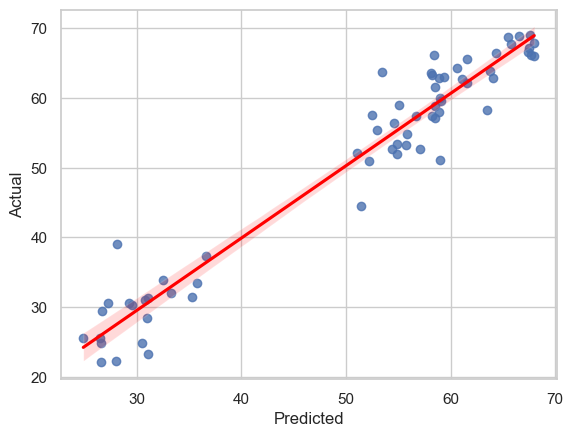

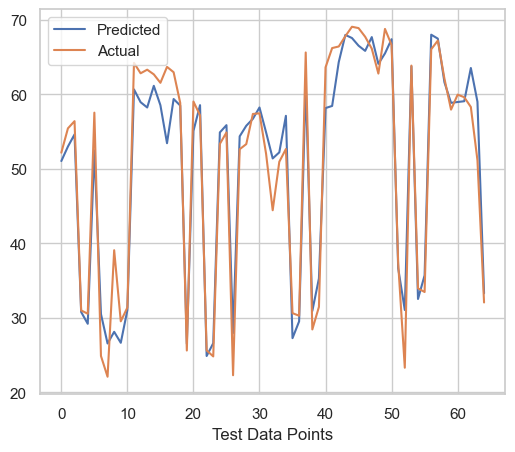

------------------------------------------------------------------------------------------------------------------------------------------------------
                 300        312        324        336        347
y_actual   52.172790  55.434646  56.400355  31.000000  30.545049
y_predict  51.048367  52.991922  54.623393  30.782956  29.200672
error       1.124423   2.442724   1.776962   0.217044   1.344377
------------------------------------------------------------------------------------------------------------------------------------------------------


In [84]:
param_grid = {'n_estimators': [50,80, 120],       # number of trees in the ensemble
             'max_depth': [15,20,30],           # maximum number of levels allowed in each tree.
             'min_samples_split': [5,15,20],    # minimum number of samples necessary in a node to cause node splitting.
             'min_samples_leaf': [3,5,8]}      # minimum number of samples which can be stored in a tree leaf.


# Initialize the RandomForestRegressor model
rf = RandomForestRegressor()
# Use GridSearchCV to perform a grid search over the parameter grid
#grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, scoring='r2')
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')
# Fit the model to the training data
grid_search.fit(X_train, y_train)
# Get the best parameters from the grid search
rf_optimal_model = grid_search.best_estimator_
rf_optimal_model
predict(rf_optimal_model, 'Random Forest')

In [88]:
X = merged_df.drop('demanda', axis=1)
y= merged_df['demanda']

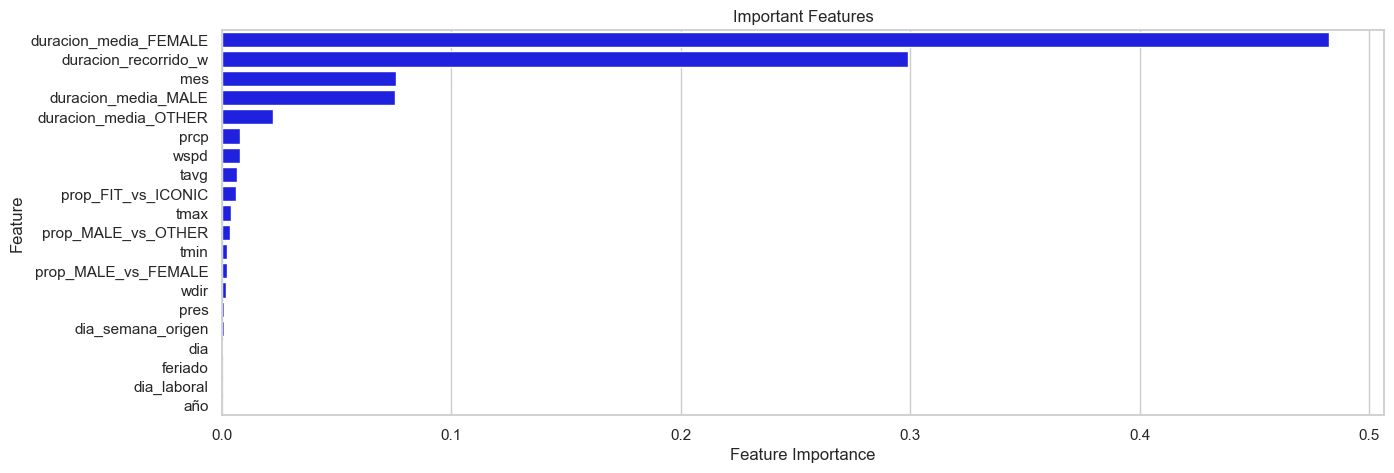

In [89]:
# feature importance
importances = rf_optimal_model.feature_importances_
# Creating a dictonary
importance_dict = {'Feature' : list(X.columns),
                   'Feature Importance' : importances}
# Creating the dataframe
importance = pd.DataFrame(importance_dict)
sorting_features = importance.sort_values(by=['Feature Importance'],ascending=False)
sorting_features
# plotting feature importance graph
plt.figure(figsize=(15,5))
bar = sns.barplot(x='Feature Importance', y='Feature', data=sorting_features, color='blue')
bar.set_title('Important Features')
plt.show()

c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:23:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:23:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\bdomecq\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:23:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "min_samples_leaf", "min_sa

train MSE : 0.0
train RMSE : 0.0
train MAE : 0.001
train R2 : 1.0
train Adj R2 : 1.0
------------------------------------------------------------------------------------------------------------------------------------------------------
test MSE : 12.981
test RMSE : 3.603
test MAE : 2.765
test R2 : 0.945
test Adj R2 : 0.919
------------------------------------------------------------------------------------------------------------------------------------------------------


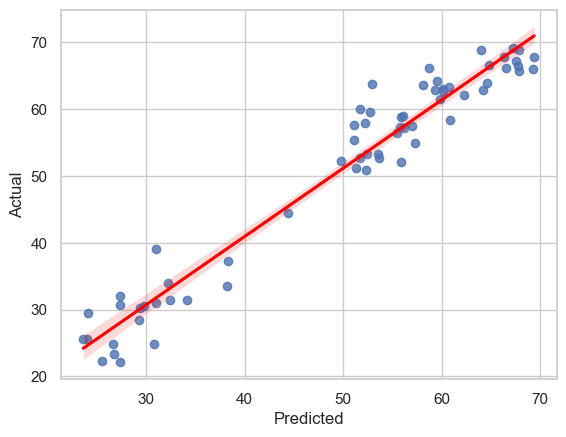

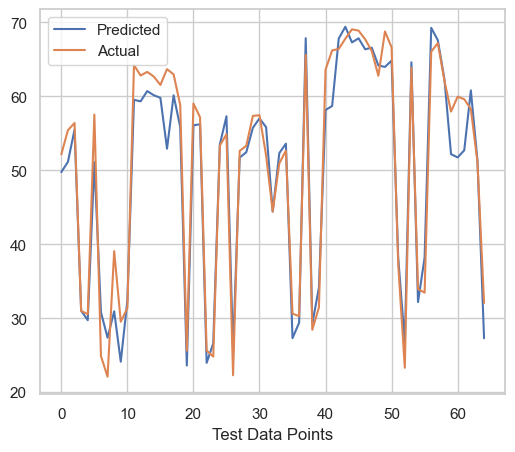

------------------------------------------------------------------------------------------------------------------------------------------------------
                 300        312        324        336        347
y_actual   52.172790  55.434646  56.400355  31.000000  30.545049
y_predict  49.762096  51.153057  55.502556  31.017059  29.738718
error       2.410693   4.281589   0.897799  -0.017059   0.806331
------------------------------------------------------------------------------------------------------------------------------------------------------


In [90]:
param_grid = {'n_estimators': [300,500],     # number of trees in the ensemble
             'max_depth': [7,8],             # maximum number of levels allowed in each tree.
             'min_samples_split': [3,5],     # minimum number of samples necessary in a node to cause node splitting.
             'min_samples_leaf': [3,5]}      # minimum number of samples which can be stored in a tree leaf.
# Initialize the RandomForestRegressor model
xgb = XGBRegressor()
# Use GridSearchCV to perform a grid search over the parameter grid
#grid_search = GridSearchCV(xgb, param_grid=param_grid, cv=5, scoring='r2')
grid_search = GridSearchCV(xgb, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')
# Fit the model to the training data
grid_search.fit(X_train, y_train)
# Get the best parameters from the grid search
xgb_optimal_model = grid_search.best_estimator_
xgb_optimal_model
predict(xgb_optimal_model, 'XGB')

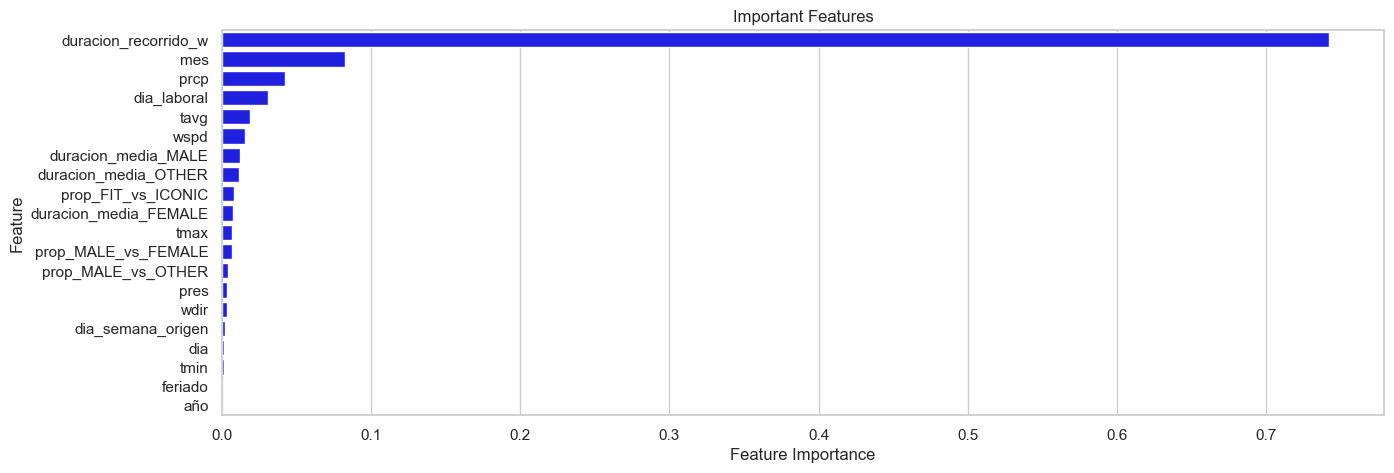

In [91]:
# feature importance
importances = xgb_optimal_model.feature_importances_
# Creating a dictonary
importance_dict = {'Feature' : list(X.columns),
                   'Feature Importance' : importances}
# Creating the dataframe
importance = pd.DataFrame(importance_dict)
sorting_features = importance.sort_values(by=['Feature Importance'],ascending=False)
sorting_features   
# plotting feature importance graph
plt.figure(figsize=(15,5))
bar = sns.barplot(x='Feature Importance', y='Feature', data=sorting_features, color='blue')
bar.set_title('Important Features')
plt.show()

RESULTADOS Y SELECCION DEL MODELO

In [92]:
# converting the model_result list into DataFrame
model_result = pd.DataFrame(model_result)
# sorting the values by test RMSE score
model_result.sort_values(by='test RMSE', ascending=True)

,model,train MSE,test MSE,train RMSE,test RMSE,train MAE,test MAE,train R2,test R2,train Adj R2,test Adj R2
5,XGB,0.000,12.981,0.000,3.603,0.001,2.765,1.000,0.945,1.000,0.919
4,Random Forest,7.422,13.569,2.724,3.684,1.960,2.769,0.967,0.942,0.965,0.916
3,Decision Tree,16.476,29.736,4.059,5.453,3.113,4.460,0.927,0.873,0.922,0.815
0,LinearRegression,25.241,32.089,5.024,5.665,4.024,4.504,0.889,0.863,0.881,0.801
2,SVM,0.534,32.413,0.731,5.693,0.315,4.462,0.998,0.861,0.997,0.799
1,Elastic Net,27.437,35.393,5.238,5.949,4.286,4.852,0.879,0.849,0.870,0.780


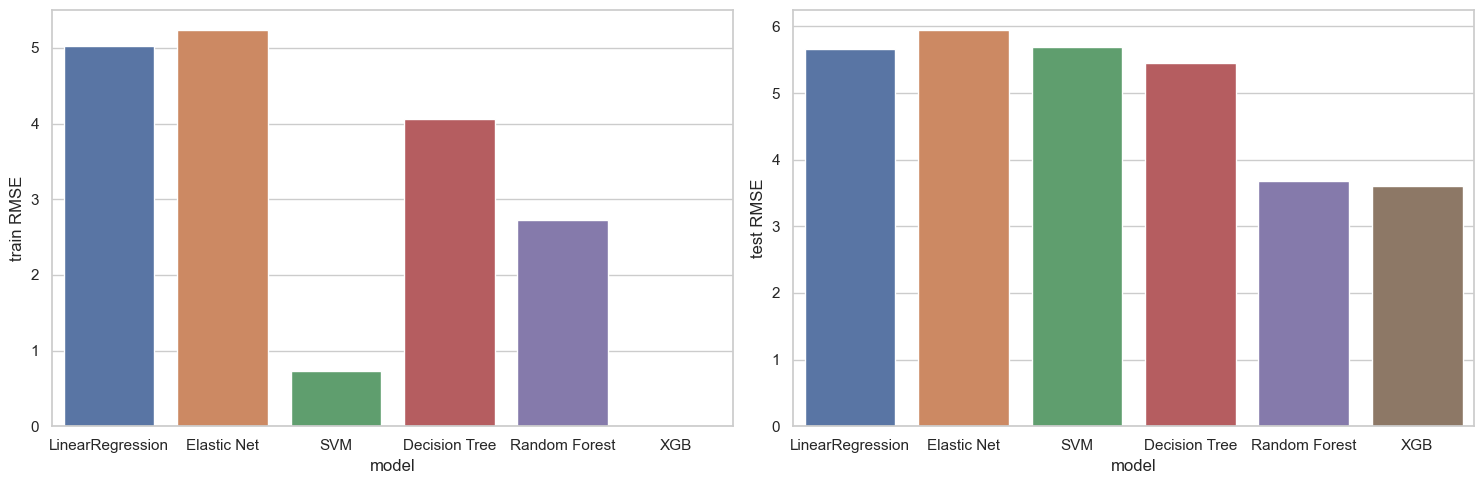

In [93]:
# plotting graph to compare model performance of all the models
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.barplot(x=model_result['model'], y=model_result['train RMSE'], ax=ax[0])           # Model Vs test R2
sns.barplot(x=model_result['model'], y=model_result['test RMSE'], ax=ax[1])       # Model Vs test Adj R2
plt.tight_layout()